[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mrvnthss/deep-learning-with-dobble/blob/main/deep-learning-with-dobble.ipynb)

# Deep Learning with Dobble

**GitHub**: https://github.com/mrvnthss/deep-learning-with-dobble

**Purpose**: A deep learning project based on the card game *Dobble*, implemented in PyTorch.

**Context**: Graded hands-on project as part of the *Deep Learning* Seminar at the [University of Giessen](https://www.uni-giessen.de)

**Authors**: 2024 Marvin Theiss, Nina Winkelmann

**License**: [GNU General Public License v3](https://www.gnu.org/licenses/gpl-3.0.html)


## Preparation

### Importing Packages

Before we start, we import all the packages that we'll be using later on. We follow the recommended order of ordering imports in Python, i.e.,
1. standard library imports
2. third-party library imports
3. local imports (not applicable here)

In [1]:
import csv
import itertools
import math
from pathlib import Path
import random
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image, ImageDraw
import torch
import torch.nn as nn
from torchvision import datasets, models
from torchvision.transforms import v2 as transforms

### Downloading Checkpoints
We also need to download some checkpoints and move them into the appropriate directory.

In [2]:
MODELS_DIR = Path('models')

**Important**: Together, the checkpoints make up 1.34 GB. Depending on your connection, downloading these may take a while.

In [3]:
url = 'https://dl.dropboxusercontent.com/scl/fi/k16l0up8g5tlcveq9prjs/models.tar.gz?rlkey=u6m92em9z8tx1q5bar83xq8xx'
datasets.utils.download_and_extract_archive(url, download_root=MODELS_DIR, filename='models.tar.gz', remove_finished=True)

100.0%


Extracting models/models.tar.gz to models


## The Card Game Dobble and Projective Planes

[*Dobble*](https://www.dobblegame.com/en/homepage/) is a **popular card game** that challenges players to spot matching symbols between pairs of cards. It was created by *Denis Blanchot* and *Jacques Cottereau* and has gained significant popularity due to its simple yet engaging gameplay.

<div style="text-align: center">
    <figure>
        <img src="reports/other/dobble-brettspiel-empfehlungen.jpg" alt="card-game-dobble" width="700">
        <br>
        <figcaption style="text-align: center">
            A set of <em>Dobble</em> cards. <a href="https://brettspiel-empfehlungen.de">&copy; 2024 Brettspiel Empfehlungen</a>. Used with permission.
        </figcaption>
    </figure>
</div>

At first glance, a deck of *Dobble* playing cards may just seem like a collection of cards with symbols randomly printed on them. However, a full deck of playing cards consists of 55 playing cards where every single playing card features 8 out of 57 distinct symbols in such a way that **each pair of cards** (no matter which pair you choose!) **shares exactly one symbol**. If you pause to think for a moment, it is by no means obvious that it should be possible to construct such a deck of playing cards in the first place! The reason we know that this must be possible is that a deck of *Dobble* playing cards can be interpreted as a mathematical structure called a **finite projective plane**. A what, you ask? Let's take it one step at a time, starting with a concept that many of us will remember from high school: lines in the Euclidean plane.


### Lines in the Euclidean Plane

Surely, you're familiar with a linear system of equations in two variables, i.e., something like this:

\begin{align*}
a_{11} x_1 + a_{12} x_2 &= b_1 \\
a_{21} x_1 + a_{22} x_2 &= b_2
\end{align*}

By rearranging these equations, we see that each equation describes a unique line in the Euclidean plane. For example, we can rewrite the first equation as

$$
x_2 = - a_{11} x_1 + b_1 ,
$$

which describes a line with slope $- a_{11}$ and $y$-intercept $b_1$. From this point of view, the solution(s) of the linear system are simply the intersection point(s) of the two lines. There are three possible outcomes:

1. The two lines are parallel (and distinct) so that they do not intersect at all.
2. The two lines intersect in exactly one point $(x_0, y_0)$.
3. The two lines are identical and intersect in infinitely many points.

By focusing on *distinct* lines, we get rid of the third case (as that is just the intersection of a line *with itself*). However, this still doesn't solve the problem of two parallel lines.


### Adding Points at Infinity

Can't we just *force* these parallel lines to intersect somehow? Yes, we can! Loosely speaking, we simly make up additional *points at infinity*, and then declare that parallel lines intersect at these made-up points. That doesn't sound convincing to you? That's pretty much what projective planes are (well, loosely speaking at least). Here is the precise mathematical definition, taken from [Wikipedia](https://en.wikipedia.org/wiki/Projective_plane#Definition):

> A **projective plane** consists of a set of lines, a set of points, and a relation between points and lines called **incidence**, having the following properties:
> 
> 1. Given any two distinct points, there is exactly one line incident with both of them.
> 2. Given any two distinct lines, there is exactly one point incident with both of them.
> 3. There are four points such that no line is incident with more than two of them.

For the sake of understanding, you can think of points and lines being "incident" with each other as a point being on a line or a line passing through a point. The term "incident" is only used to highlight the symmetric relationship between points and lines of a projective plane. Also, the third condition is a technicality to rule out so-called *degenerate* cases that aren't interesting from a mathematical perspective. In case you're curious, here are examples of degenerate projective planes:

<div style="text-align: center">
    <figure>
        <img src="https://upload.wikimedia.org/wikipedia/en/8/81/Degenerate_planes_wec.svg" alt="degenerate-cases" width="300">
        <br>
        <figcaption style="text-align: center">
            Non-empty degenerate projective planes. <a href="https://creativecommons.org/publicdomain/zero/1.0/deed.en"> CC0</a>.
        </figcaption>
    </figure>
</div>

Let's figure out what the first two conditions imply in terms of a deck of *Dobble* playing cards. We can think of playing cards representing the lines and symbols representing the points of a projective plane. We start with the first condition:

> Given any two distinct points, there is exactly one line incident with both of them.

This implies that, if we randomly pick two symbols from all symbols available, we will find exactly one playing card featuring both of these symbols. Why is this necessary? Let's assume that the opposite was true, i.e., we could find at least two cards both featuring the same two symbols. This clearly contradicts the fact that each pair of *Dobble* cards shares *only one* symbol. Note that this condition also rules out the possibility that there is a pair of symbols that does not appear on *any* playing card. As a matter of fact, this is acutally the case for a deck of *Dobble* playing cards. However, this is only due to the fact that, for some reason, the full deck only includes 55 of the 57 possible different playing cards. Now, let's look at the second condition.

> Given any two distinct lines, there is exactly one point incident with both of them.

This guarantees that, if we choose any two cards from a deck of playing cards, these two cards will share one (and only one) symbol between them.


### Finite Projective Planes and Incidence Matrices

Finite projective planes are exactly what you'd expect them to be: they're projective planes that consist of only finitely many points and lines. For a finite projective plane, one can show that there exists an integer $N$ called the **order** of the projective plane such that...

- the number of points and lines is given by $N^2 + N + 1$,
- there are $N + 1$ points on each line,
- there are $N + 1$ lines passing through each point.

In particular, every projective plane (finite or infinite) has as many points as it has lines. Before we move on, let's take a look at some examples. First, here is an illustration of a finite projective plane of order 3:

<div style="text-align: center">
    <figure>
        <img src="https://i2.wp.com/puzzlewocky.com/wp-content/uploads/2018/01/ProjectivePlaneOrder3.jpg?w=750&ssl=1" alt="projective-plane-order-3" width="300">
        <br>
        <figcaption style="text-align: center">
            A finite projective plane of order 3. <a href="https://puzzlewocky.com/math-fun/from-orthogonal-latin-squares-to-finite-projective-planes/"> &copy; 2024 Brendan Conley</a>.
        </figcaption>
    </figure>
</div>

The same projective plane can also be illustrated in a symmetric fashion:

<div style="text-align: center">
    <figure>
        <img src="https://i0.wp.com/puzzlewocky.com/wp-content/uploads/2018/01/SymmetricalProjectivePlaneOrder3.jpg?w=770&ssl=1" alt="projective-plane-order-3" width="250">
        <br>
        <figcaption style="text-align: center">
            A finite projective plane of order 3. <a href="https://puzzlewocky.com/math-fun/from-orthogonal-latin-squares-to-finite-projective-planes/"> &copy; 2024 Brendan Conley</a>.
        </figcaption>
    </figure>
</div>

Finally, here is a projective plane of order 4:

<div style="text-align: center">
    <figure>
        <img src="https://i1.wp.com/puzzlewocky.com/wp-content/uploads/2016/02/pporder4.jpg?w=471&ssl=1" alt="projective-plane-order-3" width="300">
        <br>
        <figcaption style="text-align: center">
            A finite projective plane of order 4. <a href="https://puzzlewocky.com/games/the-math-of-spot-it/"> &copy; 2024 Brendan Conley</a>.
        </figcaption>
    </figure>
</div>

Finite projective planes provide the added benefit that they can be represented by and constructed from so-called **incidence matrices**. An incident matrix is simply a matrix where the rows correspond to lines and the columns correspond to points such that the entry associated with a given line-point-pair indicates whether this line and point are incident. Here is an example of an incidence matrix of a finite projective plane of order 3:

<div style="text-align: center">
    <figure>
        <img src="https://miro.medium.com/v2/resize:fit:1400/1*gZY9SSoO-LHFSHAw1ENY5Q.png" alt="incidence-matrix" width="300">
        <br>
        <figcaption style="text-align: center">
            The incidence matrix of a finite projective plane of order 3. <a href="https://mickydore.medium.com/dobble-theory-and-implementation-ff21ddbb5318"> &copy; 2021 Micky Dore</a>.
        </figcaption>
    </figure>
</div>

The incidence matrices of finite projective planes of order $N = p^k$ with $p$ prime (i.e., $N$ is a *prime power*) can be computed algorithmically, and this is exactly what we'll do later on to construct our own decks of *Dobble* playing cards. Interestingly, the order of all *known* finite projective planes is a prime power, and the existence of finite projective planes of orders that are not a prime-power is still an open research question.


### Further Reading

There are several well-written articles on the internet covering the mathematical underpinnings of *Dobble* in even greater detail than what we have discussed here. If you're interested to learn more, here is a non-exhaustive list:

- [The maths behind Dobble](https://mickydore.medium.com/dobble-theory-and-implementation-ff21ddbb5318) by *Micky Dore*
- [The Dobble algorithm](https://mickydore.medium.com/the-dobble-algorithm-b9c9018afc52) by *Micky Dore*
- [Finite projective planes and the math of Spot It!](https://puzzlewocky.com/games/the-math-of-spot-it/) on *puzzlewocky.com*
- [Dobble](https://www.petercollingridge.co.uk/blog/mathematics-toys-and-games/dobble/) by *Peter Collingridge*
- [Ein Einblick in die Mathematik hinter dem Kartenspiel Dobble](https://unipub.uni-graz.at/obvugrhs/download/pdf/6499156?originalFilename=true) by *Christian Kathrein* [in German]


## Creating our own Dobble Playing Cards

Essentially, there are (at least) two alternatives to generate the data needed to train a network so that it learns to play the card game *Dobble*. Either, one purchases (or already owns) the actual game and takes pictures of all of the individual cards, or one generates their own *Dobble* playing cards from scratch. For this project, we chose the second option, i.e., we decided to generate images of custom *Dobble* cards using popular image-processing libraries such as [OpenCV](https://pypi.org/project/opencv-python/) and [Pillow](https://pypi.org/project/Pillow/).

This approach has several *advantages*, so let's just highlight a few of these:

- **Multiple decks of cards**: Instead of being stuck with a single deck of cards, we can (theoretically) generate infinitely many different sets.
- **Full control over the dataset**: We can control every last detail of our *Dobble* cards. For example, we can control the color of the individual symbols, their size, their placement on the card, and so on.
- **Easier data generation**: When working with networks, we aim to feed images of pairs of cards into the networks and then ask the networks to find the unique symbol that is present on both cards. For a classic deck of *Dobble* cards, there are 1,596 possible combinations of cards. Manually taking pictures of all of these pairs of cards would be immensely time-consuming. On the contrary, generating images of pairs of cards is straightforward once all of the individual cards have been created.

**Here's how we will go about creating our datasets**:
First, we need to generate images of individual cards. To do so, we first have to create **empty playing cards**. This is going to be easy as this equates to generating square images of a white disk against a transparent background. Next, we need to find an **open-source library of emojis** that we can use as the symbols on our *Dobble* cards. Once we have that, we need to find a way to **place** these **individual emojis** onto the empty playing cards without having emojis overlap. If possible, we want to replicate the way that the symbols are arranged on actual *Dobble* cards: The centers of the individual symbols vary across cards and so do the sizes of the symbols. After we have implemented the necessary algorithms to achieve this, we are in the position to **generate individual *Dobble*-like playing cards**. Next, we need to come up with an algorithm that tells us **which emojis to place on which card** so that every two cards will share one and only one common emoji. Essentially, this boils down to implementing an algorithm that computes the incidence matrix of a finite projective plane of a given order. Given such an algorithm we can **systematically create all the cards** that make up a full deck of *Dobble* playing cards. Finally, we need to **find all pairs of cards**, which will serve as the dataset(s) for our project.

Let's start by implementing a function that returns an empty playing card. This should be easy.


### Empty Playing Cards

As just mentioned, the starting point for our custom *Dobble* playing cards will be square images consisting of nothing but a white disk against a transparent background.

In [4]:
def create_empty_card(
        image_size: int,
        return_pil: bool = True) -> Image.Image | np.ndarray:
    """Create a square image of a white disk against a transparent background.

    Args:
        image_size (int): The size of the square image in pixels.
        return_pil (bool): Whether to return a PIL Image (True) or a NumPy array (False).  Defaults to True.

    Returns:
        Image.Image or np.ndarray: The generated image of a white disk against a transparent background.
    """
    # Create a new transparent image with RGBA mode
    image = Image.new('RGBA', (image_size, image_size), (0, 0, 0, 0))

    # Create a new draw object and draw a white disk onto the image
    draw = ImageDraw.Draw(image)
    draw.ellipse((0, 0, image_size, image_size), fill=(255, 255, 255, 255))

    return image if return_pil else np.array(image)


Let's check out what this looks like. To actually see the white disk, we make the transparent background fully opaque.

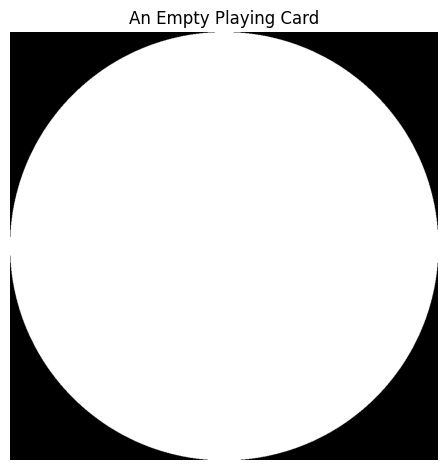

In [5]:
image_size = 1024
empty_playing_card = create_empty_card(image_size, return_pil=False)
empty_playing_card[..., 3] = 255

plt.imshow(empty_playing_card)
plt.title('An Empty Playing Card')
plt.axis('off')
plt.tight_layout()
plt.show()

Now, let's move on to the fun part: emojis.


### Emojis

The emojis for this project are taken from [OpenMoji](https://openmoji.org) and are free to use under the [CC BY-SA 4.0](https://creativecommons.org/licenses/by-sa/4.0/) license, which is compatible with the [GNU General Public License v3](https://www.gnu.org/licenses/gpl-3.0.en.html). Information on the compatibility of *CC BY-SA 4.0* with *GPLv3* can be found [here](https://creativecommons.org/share-your-work/licensing-considerations/compatible-licenses).

We have manually downloaded the emojis and placed them into the following directory (relative to this notebook): `data/external/emojis/classic-dobble/`. Inside this directory, there are two subdirectories called `color` and `outline`. These contain the colored versions of the emojis and just their outlines, respectively. 

**Note**: The directory `data/external/emojis/` is the general directory where we will store different sets of emojis (e.g., animals, food, etc.). Each of these sets should then include the two subdirectories `color` and `outline` containing the corresponding images.

In [6]:
EMOJIS_DIR = Path('data/external/emojis')

We have curated a set of emojis that is (somewhat) close to the images used in the original *Dobble* card game. Before we move on, we download this set of emojis along with some data on circle packings that we'll turn to later.

In [7]:
url = 'https://dl.dropboxusercontent.com/scl/fi/v8k2uga5eofitjts1zlbl/external.tar.gz?rlkey=oftklo7cbs9eg7msi4c6bsasi'
datasets.utils.download_and_extract_archive(url, download_root='data', filename='external.tar.gz', remove_finished=True)

100.0%


Extracting data/external.tar.gz to data


To create our playing cards, we will need to be able to **obtain the names of all emojis available in a given set** of emojis (i.e., directory) at once. Let's implement a function that does just that.

In [8]:
def get_emoji_names(
        emoji_set: str,
        outline_only: bool = False) -> list[str]:
    """Retrieve the names of all emojis in the specified set of emojis.

    Args:
        emoji_set (str): The name of the emoji set to use (e.g., 'classic-dobble').
        outline_only (bool): Specifies whether to retrieve names of emojis with outline only.  Defaults to False.

    Returns:
        list[str]: A list of names of all emojis in the specified set.
    """
    dir_path = EMOJIS_DIR / emoji_set / ('outline' if outline_only else 'color')

    emoji_names = []
    for file_path in dir_path.iterdir():
        if file_path.suffix == '.png':
            # Extract the base name without extension (i.e., without '.png')
            emoji_name = file_path.stem
            emoji_names.append(emoji_name)
    emoji_names.sort()

    return emoji_names


To make sure that this function works as expected, let's print the names of all the emojis of the `classic-dobble` set.

In [9]:
classic_dobble_emoji_names = get_emoji_names('classic-dobble')
for name in classic_dobble_emoji_names:
    print(name)

anchor
baby-bottle
bison
bomb
cactus
candle
carrot
cheese-wedge
chess-pawn
clown-face
deciduous-tree
dog-face
dragon
droplet
drunk-person
eye
fire
four-leaf-clover
ghost
green-apple
grinning-cat-with-smiling-eyes
hammer
hand-with-fingers-splayed
heart
high-heeled-shoe
high-voltage
ice
key
lady-beetle
last-quarter-moon-face
light-bulb
locked
maple-leaf
microbe
mount-fuji
mouth
musical-score
oncoming-police-car
pencil
red-exclamation-mark
red-question-mark
rosette
scissors
skull-and-crossbones
snowflake
snowman-without-snow
spider
spider-web
spouting-whale
stop-sign
sun-with-face
sunglasses
t-rex
timer
turtle
twitter
yin-yang


Next, we need a function that takes as input the name of the set of emojis (e.g., `classic-dobble`) as well as the name of the emoji (e.g., `dog-face`) and then **loads the corresponding emoji image into memory** and returns it.

In [10]:
def load_emoji(
        emoji_set: str,
        emoji_name: str,
        outline_only: bool = False,
        return_pil: bool = False) -> Image.Image | np.ndarray:
    """Load an emoji from the specified set of emojis.

    Args:
        emoji_set (str): The name of the set of emojis (e.g., 'classic-dobble').
        emoji_name (str): The name of the emoji to load.
        outline_only (bool): Whether to load the outline-only version of the emoji.  Defaults to False.
        return_pil (bool): Whether to return a PIL Image (True) or a NumPy array (False).  Defaults to False.

    Returns:
        Image.Image or np.ndarray: The loaded emoji image.

    Raises:
        ValueError: If the specified emoji file is not found or is not a valid PNG file.
    """
    # Create the file path pointing to the emoji that we want to load
    which_type = 'outline' if outline_only else 'color'
    file_path = EMOJIS_DIR / emoji_set / which_type / (emoji_name + '.png')

    # Check if the file exists and verify that it is a valid PNG file
    if file_path.is_file():
        try:
            # Verify that the file is a valid PNG file, then load it
            Image.open(file_path).verify()
            emoji_image = Image.open(file_path)

            # Convert to RGBA mode if necessary
            if emoji_image.mode != 'RGBA':
                emoji_image = emoji_image.convert('RGBA')

            return emoji_image if return_pil else np.array(emoji_image)

        except (IOError, SyntaxError) as e:
            raise ValueError(f'Failed to load emoji: {file_path} is not a valid PNG file.') from e
    else:
        raise ValueError(f'Failed to load emoji: {file_path} does not exist.')


Let's use this function to visualize all the emojis in the `classic-dobble` set.

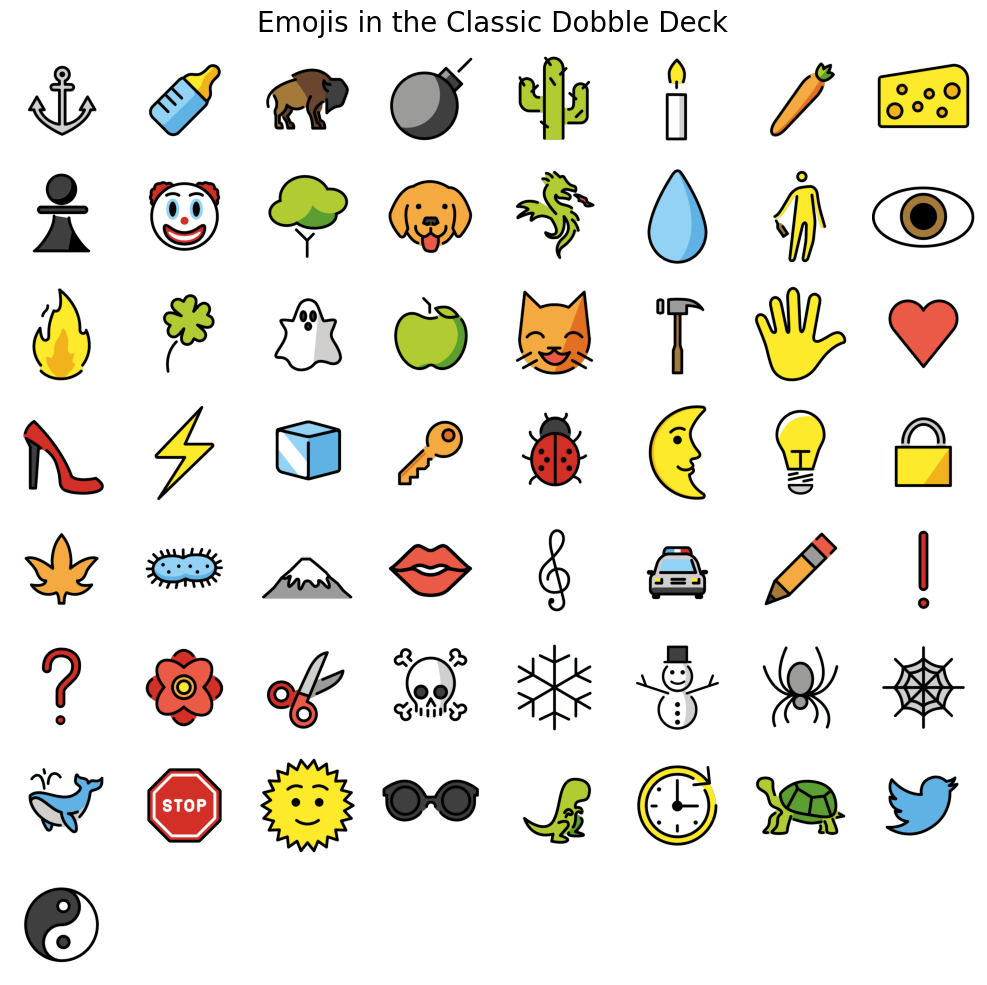

In [11]:
fig, axes = plt.subplots(8, 8, figsize=(10, 10))
file_path = Path('reports/figures/emojis/classic-dobble-emojis.png')

for count, ax in enumerate(axes.flat):
    if count < len(classic_dobble_emoji_names):  # Check if there are still emojis remaining
        emoji_image_np = load_emoji('classic-dobble', classic_dobble_emoji_names[count])
        ax.imshow(emoji_image_np)
        ax.axis('off')
    else:
        ax.axis('off')

plt.suptitle('Emojis in the Classic Dobble Deck', size=20)
plt.tight_layout()
file_path.parent.mkdir(parents=True, exist_ok=True)
if not file_path.exists():
    _ = plt.savefig(file_path)
plt.show()

Next, we write a function that **manipulates the size of each emoji** in such a way that all image content is within the circle that's inscribed in the square made up of the square image. It will become apparent later why this is useful.

In [12]:
def rescale_emoji(
        emoji_image: np.ndarray,
        scale: float = 0.99,
        return_pil: bool = True) -> Image.Image | np.ndarray:
    """Rescale an emoji so that it fits inside the circle inscribed in the square image.

    Args:
        emoji_image (np.ndarray): The emoji image to rescale as a NumPy array.
        scale (float): Determines to what extent the emoji should fill the inscribed circle.  Defaults to 0.99.
        return_pil (bool): Whether to return a PIL Image (True) or a NumPy array (False).  Defaults to True.

    Returns:
        Image.Image or np.ndarray: The rescaled emoji image.

    Raises:
        ValueError: If the 'emoji_image' is not a NumPy array or not a square image.
        ValueError: If the 'scale' is not in the range of (0, 1].
    """
    # Ensure that the input image is a NumPy array
    if not isinstance(emoji_image, np.ndarray):
        raise ValueError('Emoji image is not a NumPy array.')

    # Ensure that the input image is a square image
    if emoji_image.shape[0] != emoji_image.shape[1]:
        raise ValueError('Input image must be a square array.')

    # Check if scale is within the range of (0, 1]
    if not 0 < scale <= 1:
        raise ValueError('Scale must be in the range of (0, 1].')
    
    # Determine non-transparent pixels
    non_transparent_px = np.argwhere(emoji_image[:, :, 3] > 0)

    # Transform coordinates so that center pixel corresponds to origin of Euclidean plane
    # NOTE: The y-axis is flipped here, which doesn't matter for computing the Euclidean norm
    radius = emoji_image.shape[0] // 2
    non_transparent_px -= radius
    
    # Determine the maximum Euclidean norm of all non-transparent pixels
    outermost_px_norm = np.max(np.linalg.norm(non_transparent_px, axis=1))

    # Compute rescaling factor and resulting target size
    target_norm = scale * radius
    rescaling_factor = target_norm / outermost_px_norm
    image_size = emoji_image.shape[0]  # size of input image
    target_size = int(image_size * rescaling_factor)  # target size of rescaled image
    
    # Convert to PIL Image and rescale
    emoji_image_pil = Image.fromarray(emoji_image)
    emoji_image_pil = emoji_image_pil.resize((target_size, target_size), Image.LANCZOS)

    # Compute offset for centering/cropping the rescaled image
    # NOTE: Taking the absolute value handles both cases (i.e., rescaling_factor < 1 and rescaling_factor > 1)
    offset = abs(target_size - image_size) // 2

    if rescaling_factor < 1:
        # Paste rescaled (smaller) image onto fully transparent image of original size
        rescaled_image = Image.new('RGBA', (image_size, image_size), (255, 255, 255, 0))
        rescaled_image.paste(emoji_image_pil, (offset, offset), mask=emoji_image_pil)
    elif rescaling_factor > 1:
        # Compute coordinates for cropping
        left = offset
        top = offset
        right = left + image_size
        bottom = top + image_size
    
        # Crop rescaled (larger) image
        rescaled_image = emoji_image_pil.crop((left, top, right, bottom))
    else:
        # Return original image
        rescaled_image = emoji_image_pil

    return rescaled_image if return_pil else np.array(rescaled_image)


Let's see the effect of the `rescale_emoji` function on an emoji that originally extends outside the inscribed circle.

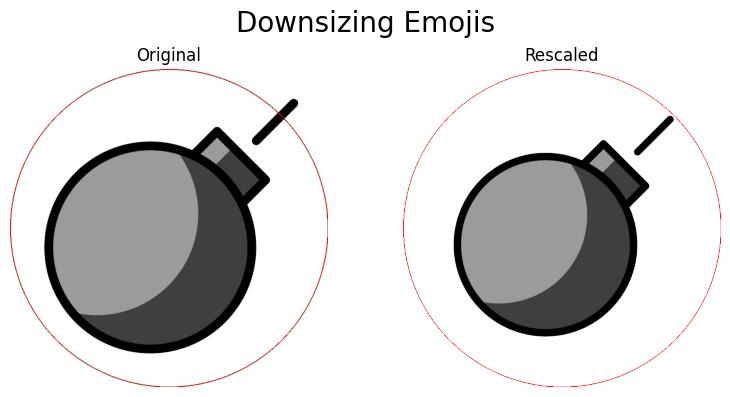

In [13]:
# Load 'bomb' emoji
bomb_np = load_emoji('classic-dobble', 'bomb')

bomb_pil = Image.fromarray(bomb_np)
bomb_rescaled_pil = rescale_emoji(bomb_np)
images = [bomb_pil, bomb_rescaled_pil]

# Prepare subplot
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
file_path = Path('reports/figures/emojis/downsized-emoji.png')

for count, image in enumerate(images):
    ax = axes[count]

    image_size = image.size[0]
    draw = ImageDraw.Draw(image)
    draw.ellipse((0, 0, image_size, image_size), outline='red', width=2)
    
    ax.imshow(image)
    ax.set_title('Original' if count == 0 else 'Rescaled')
    ax.axis('off')

plt.suptitle('Downsizing Emojis', size=20)
plt.tight_layout()
if not file_path.exists():
    _ = plt.savefig(file_path)
plt.show()

Next, let's look at an example where the emoji does not make use of all available space.

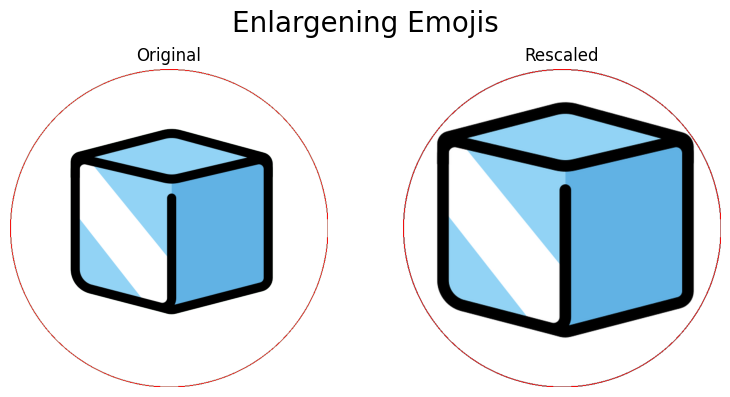

In [14]:
# Load 'ice' emoji
ice_np = load_emoji('classic-dobble', 'ice')

ice_pil = Image.fromarray(ice_np)
ice_rescaled_pil = rescale_emoji(ice_np)
images = [ice_pil, ice_rescaled_pil]

# Prepare subplot
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
file_path = Path('reports/figures/emojis/enlarged-emoji.png')

for count, image in enumerate(images):
    ax = axes[count]

    image_size = image.size[0]
    draw = ImageDraw.Draw(image)
    draw.ellipse((0, 0, image_size, image_size), outline='red', width=2)
    
    ax.imshow(image)
    ax.set_title('Original' if count == 0 else 'Rescaled')
    ax.axis('off')

plt.suptitle('Enlargening Emojis', size=20)
plt.tight_layout()
if not file_path.exists():
    _ = plt.savefig(file_path)
plt.show()

Finally, let's load and resize all the emojis in the `classic-dobble` set.

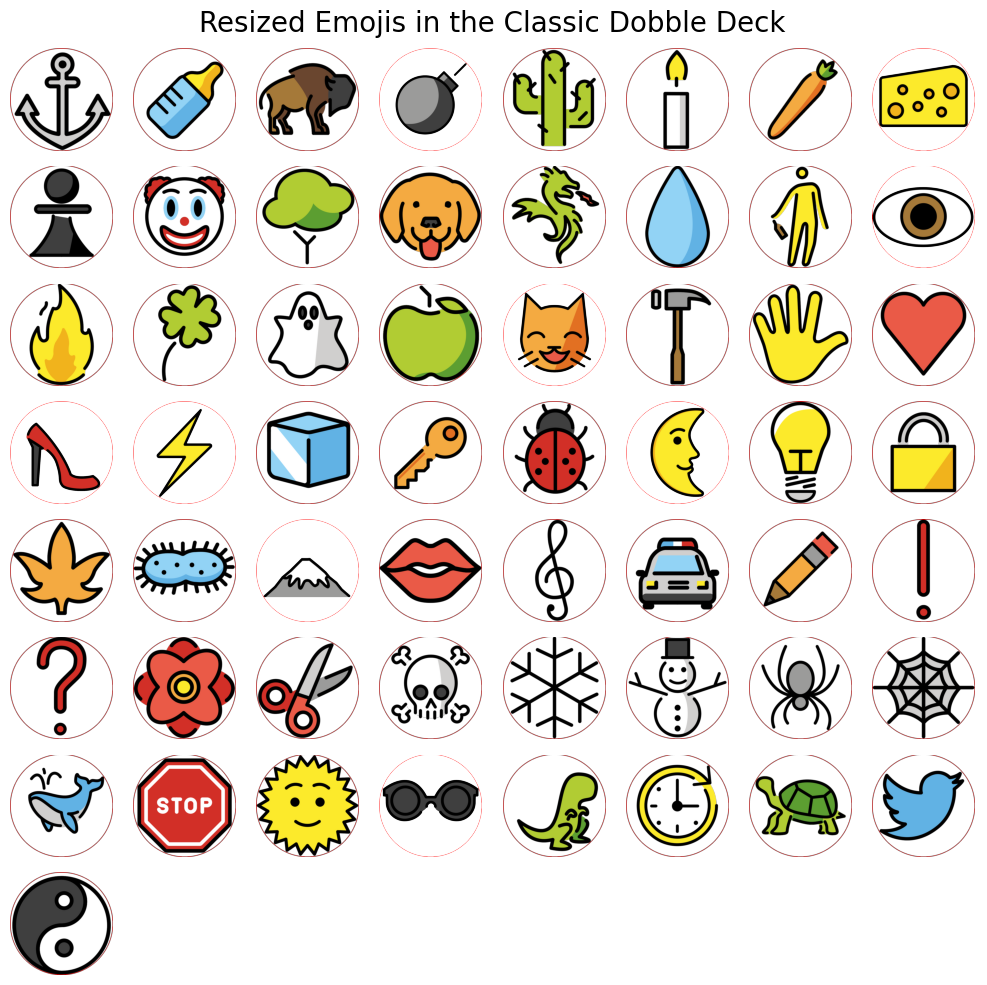

In [15]:
fig, axes = plt.subplots(8, 8, figsize=(10, 10))
file_path = Path('reports/figures/emojis/resized-classic-dobble-emojis.png')

for count, ax in enumerate(axes.flat):
    if count < len(classic_dobble_emoji_names):  # Check if there are still emojis remaining
        # Load and resize emoji image
        emoji_image_pil = rescale_emoji(load_emoji('classic-dobble', classic_dobble_emoji_names[count]))

        # Draw inscribed circle
        image_size = emoji_image_pil.size[0]
        draw = ImageDraw.Draw(emoji_image_pil)
        draw.ellipse((0, 0, image_size, image_size), outline='red', width=4)

        # Show image
        ax.imshow(emoji_image_pil)
        ax.axis('off')
    else:
        ax.axis('off')

plt.suptitle('Resized Emojis in the Classic Dobble Deck', size=20)
plt.tight_layout()
if not file_path.exists():
    _ = plt.savefig(file_path)
plt.show()

By now, we know which emojis exist in which set, we can load any of these emojis into memory, and we can manipulate their size appropriately. Next, we need a function that **pastes an individual emoji** onto another image (which will be our playing card, of course).

In [16]:
def place_emoji(
        image: Image.Image,
        emoji_image: Image.Image,
        emoji_size: int,
        emoji_center: tuple[int, int],
        rotation_angle: float = None,
        return_pil: bool = True) -> Image.Image | np.ndarray:
    """Place an emoji on the given image at the specified coordinates with the specified size.

    Args:
        image (Image.Image): The image on which the emoji is to be placed.
        emoji_image (Image.Image): The emoji image to be placed on the image.
        emoji_size (int): The desired size of the emoji in pixels when placed on the image.
        emoji_center (tuple[int, int]): The coordinates of the center of the emoji in the form (x, y).
        rotation_angle (float): The angle (in degrees) by which to rotate the emoji.  Defaults to None.
        return_pil (bool): Whether to return a PIL Image (True) or a NumPy array (False).  Defaults to True.

    Returns:
        Image.Image or np.ndarray: The image with the emoji placed on it.

    Raises:
        ValueError: If the 'rotation_angle' is provided but is outside the valid range [0, 360).
    """
    x_center, y_center = emoji_center

    # Calculate the top-left coordinates of the emoji based on the center coordinates and size
    x_left = x_center - emoji_size // 2
    y_top = y_center - emoji_size // 2

    # Resize the emoji to the specified size
    emoji_image = emoji_image.resize((emoji_size, emoji_size))

    # Rotate the emoji if a rotation angle is provided
    if rotation_angle:
        if 0 <= rotation_angle < 360:
            emoji_image = emoji_image.rotate(rotation_angle)
        else:
            raise ValueError('Invalid rotation angle: must be in the range [0, 360).')

    # Paste the emoji onto the original image at the specified coordinates
    image.paste(emoji_image, (x_left, y_top), mask=emoji_image)

    return image if return_pil else np.array(image)


Let's take the `four-leaf-clover` emoji, resize it, rotate it by 15 degrees clockwise, and place it onto the empty playing card we created earlier.

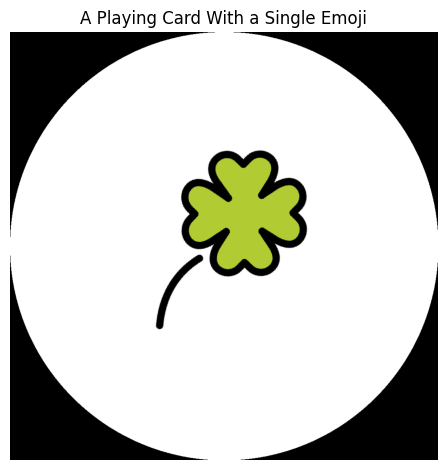

In [17]:
empty_playing_card = create_empty_card(1024)
clover_image = rescale_emoji(load_emoji('classic-dobble', 'four-leaf-clover'))
emoji_size = 512
center = (512, 512)
rotation_angle = 345  # 15 degrees clockwise correspond to 345 degrees counterclockwise
playing_card_with_single_emoji = place_emoji(
    empty_playing_card, clover_image, emoji_size, center, rotation_angle, return_pil=False
    )
playing_card_with_single_emoji[..., 3] = 255

plt.imshow(playing_card_with_single_emoji)
plt.title('A Playing Card With a Single Emoji')
plt.axis('off')
plt.tight_layout()
plt.show()

Now that the fun part is done, we need to find a **systematic way of placing multiple emojis** onto a single playing card. When doing so, we want to ...

* utilize the available space of each playing card as much as possible,
* make sure that no two emojis overlap.

To accomplish this, we rely on results from a mathematical branch called *circle packing*.


### Circle Packing

Why do we need to deal with the theory of *circle packing*? Well, here is an extract of the [Wikipedia article](https://en.wikipedia.org/wiki/Circle_packing) on the theory of circle packing:

> *In geometry, circle packing is the study of the arrangement of circles (of equal or varying sizes) on a given surface such that **no overlapping** occurs and so that **no circle can be enlarged without creating an overlap**.*

Sounds familiar? Loosely speaking, packings satisfying the two conditions highlighted in **bold** are called *optimal*. So, here's the general approach we will take: For a given number $n$ of emojis that we want to place on a playing card, we choose an optimal circle packing consisting of $n$ circles and we center each emoji on the center of one of the circles. The size of the emoji will be determined by the size of the corresponding circle (i.e., its diameter). This works out quite well since ...

* the emojis provided by [OpenMoji](https://openmoji.org) are square images (618 x 618 pixels) with a transparent background,
* most emojis do not extend much into the corners of the image due to the [styleguide](https://openmoji.org/styleguide/#styleguide) that's used by [OpenMoji](https://openmoji.org).

For thus emojis that do extend into the corners of the image, our `rescale_emoji` function will scale down the emoji so that it does not overlap with any other emoji on the playing card. Thus, all we need are optimal packings for different numbers of circles. That way we can create *Dobble* decks with varying numbers of symbols per card. Ideally, we also have multiple (optimal) packings for a fixed number of circles. This would allow us to have different layouts across playing cards of a single deck. Luckily, Prof. Dr.-Ing. [Eckehard Specht](https://www.ltv.ovgu.de/Mitarbeiter/Lehrstuhlinhaber/Prof_+Eckehard+Specht-p-210.html) provides an incredible amount of data on optimal packings on his website [packomania.com](http://www.packomania.com). From this website, we have downloaded the data that we need and placed it into the following directory (relative to this notebook): `data/external/packings/`.

In [18]:
PACKINGS_DIR = Path('data/external/packings')

 Inside this directory, there are the following five subdirectories:

- `cci`
- `ccib`
- `ccic`
- `ccir`
- `ccis`

The names of these subdirectories are simply the names that Prof. Dr.-Ing. Eckehard Specht uses for the different types of packings that he provides on his website (e.g., the data in the `cci` directory was taken from [http://hydra.nat.uni-magdeburg.de/packing/**cci**/**cci**.html](http://hydra.nat.uni-magdeburg.de/packing/cci/cci.html)). All of these subdirectories qualitatively contain the same data:

- Multiple text files containing the **coordinates of each circle** in the packing. The file names consist of the name of the directory followed by the number of circles in the circle packing (e.g., `cci4.txt` or `ccir32.txt`). All text files consist of three columns: the first column stores a simple counter, the second column contains the $x$-coordinate, and the third column contains the $y$-coordinate of the center of each circle. The coordinates of these circle centers have to be interpreted in relation to the large circle that contains all of the smaller circles. This large circle is centered at $(0, 0)$ and has a radius of $1$, i.e., it is defined by the equation $x^2 + y^2 = 1$.
- A single text file `radius.txt` that stores the **radius of the largest circle** of each circle packing. This file contains two columns: the first one specifies the number of circles in the circle packing and the second one provides the radius of the largest circle in the packing. The radii of all the other circles can be computed based on this radius. We will get back to this later. As was the case for the coordinate values, these radii have to be interpreted in relation to the radius of the large circle containing all of the smaller circles.

Generally, this data is available for circle packings where the number of circles are integers up to $n = 50$ that can be expressed as $p^k + 1$ with $p$ being prime (i.e., integers that immediately follow a prime power).

**Important**: For $n = 3, 4$ this data is **only** available for circle packings of type `cci`.

Next, let's define a dictionary `PACKING_TYPES_DICT` that stores all the different types of packings that are available in our directory `data/external/packings/`. The value associated with each key is a tuple consisting of ...
- a function that can be used to compute the remaining radii of a circle packing of that type,
- a string that indicates whether this function is monotonically increasing or decreasing.

In [19]:
PACKING_TYPES_DICT = {
    'cci': (lambda n: 1, 'increasing'),
    'ccir': (lambda n: n ** (1/2), 'increasing'),
    'ccis': (lambda n: n ** (-1/2), 'decreasing'),
    'ccib': (lambda n: n ** (-1/5), 'decreasing'),
    'ccic': (lambda n: n ** (-2/3), 'decreasing')
    }

We now have all the raw data that we need for our project. What's needed now, is a **set of functions that allows us to conveniently access this data**. Essentially, we want to be able to specify

* the type of packing that we want to use (i.e., one of the keys in the `PACKING_TYPES_DICT`),
* the number of emojis that we want to place on a playing card,
* the size of the playing card in pixels (i.e., the size of the square image of a white disk against a transparent background),

and we want to get back the coordinates (in pixels) of where to place each emoji as well as each emoji's size (in pixels). We could then use this information to iteratively place single emojis on our playing cards using the `place_emoji` function. Let's break the process of reading in and preprocessing the packing data down into three simple steps:

1. Read in the raw data (i.e., coordinates of all circles and radius of the largest circle) for a given packing
2. Based on the radius of the largest circle and the type of packing, compute the radii of all remaining circles in the packing
3. Convert the data into pixel values based on the size of the playing card that ought to be generated

Let's start with the first step of **reading in the raw data**.

In [20]:
def read_coordinates_from_file(
        num_circles: int,
        packing_type: str) -> list[list[float]]:
    """Read the coordinates of the specified circle packing from a text file.

    Args:
        num_circles (int): Number of circles in the packing.
        packing_type (str): Type of circle packing.

    Returns:
        list[list[float]]: The coordinates of the circles in the packing.

    Raises:
        FileNotFoundError: If the text file for the specified packing type and number of circles is not found.
    """
    file_name = PACKINGS_DIR / packing_type / (packing_type + str(num_circles) + '.txt')

    try:
        with open(file_name, 'r') as file:
            # Read values line by line, split into separate columns and get rid of first column of text file
            coordinates = [line.strip().split()[1:] for line in file.readlines()]
            coordinates = [[float(coordinate) for coordinate in coordinates_list] for coordinates_list in coordinates]
        return coordinates
    except FileNotFoundError:
        raise FileNotFoundError(f"Coordinates file for '{packing_type}' packing with {num_circles} circles not found.")


def read_radius_from_file(
        num_circles: int,
        packing_type: str) -> float:
    """Read the radius of the largest circle of the specified circle packing from a text file.

    Args:
        num_circles (int): Number of circles in the packing.
        packing_type (str): Type of circle packing.

    Returns:
        float: The radius of the largest circle of the packing.

    Raises:
        FileNotFoundError: If the text file for the specified packing type is not found.
        ValueError: If no radius is found for the specified packing type and number of circles.
    """
    file_name = PACKINGS_DIR / packing_type / 'radius.txt'

    try:
        with open(file_name, 'r') as file:
            for line in file:
                values = line.strip().split()
                if len(values) == 2 and int(values[0]) == num_circles:
                    return float(values[1])
        raise ValueError(f"No radius found for packing type '{packing_type}' with {num_circles} circles.")
    except FileNotFoundError:
        raise FileNotFoundError(f"Radius file for '{packing_type}' packing not found.")


As mentioned before, the `radius.txt` file in each subdirectory contains only the radius of the largest circle in each packing. The radii of the remaining circle can be computed as follows: Each type of packing is described by the radii of the circle it's made up of. For example, the radii (relative to the radius of the largest circle in the packing) of the packings of type `ccir` are described by the function $r_i = \sqrt{i}$. Let's look at a concrete example: Assume that we want to compute the radii of all of the circles in a packing of type `ccir` with $5$ circles. The function $r_i$ then yields the following values:

* $r_1 = \sqrt{1} = 1$
* $r_2 = \sqrt{2} \approx 1.4142$
* $r_3 = \sqrt{3} \approx 1.7321$
* $r_4 = \sqrt{4} = 2$
* $r_5 = \sqrt{5} \approx 2.2361$

As we can see right away, these are not the final radii (remember that the large circle that contains all the smaller circles only has a radius of 1!). Instead, these values simply describe the ratios of the circles in a packing *relative to each other*. To obtain the absolute radii, we first take the radius of the largest circle in the packing (which we obtain from the `radius.txt` file) and divide it by the largest value of the sequence of values $r_1, \dots, r_5$. In this particular case, this gives us $0.49454334 / 2.2361 \approx 0.2212$. All we need to do now is multiply the sequence of values $r_1, \dots, r_5$ by this constant factor to obtain the final radii:

* $r_1 \times 0.2212 \approx 0.2212$
* $r_2 \times 0.2212 \approx 0.3128$
* $r_3 \times 0.2212 \approx 0.3831$
* $r_4 \times 0.2212 \approx 0.4423$
* $r_5 \times 0.2212 \approx 0.4945$

These are the actual radii that we were looking for. Note that the final value in the list above coincides with the radius supplied in the `radius.txt` file. This is no coincidence because this value was computed as
$$
r_5 \times 0.2212 = r_5 \times \frac{0.4945}{r_5} = 0.4945 \, .
$$

Let's turn all of this into a function!

In [21]:
def compute_radii(
        num_circles: int,
        packing_type: str,
        largest_radius: float) -> list[float]:
    """Compute the radii of circles in a circle packing.

    Args:
        num_circles (int): Total number of circles in the packing.
        packing_type (str): Type of circle packing.
        largest_radius (float): Radius of the largest circle in the packing.

    Returns:
        list[float]: The computed radii of the circles in the packing.
    """
    radius_function, monotonicity = PACKING_TYPES_DICT[packing_type]
    function_values = [radius_function(n + 1) for n in range(num_circles)]

    # If the function 'radius_function' is decreasing, we reverse the order
    # of 'function_values' so that the values are listed in increasing order
    function_values.reverse() if monotonicity == 'decreasing' else None

    ratio = largest_radius / function_values[-1]
    radii = [function_values[n] * ratio for n in range(num_circles)]

    return radii


Now that we have both, the circle centers as well as the radii, we need to convert these values into pixel values based on the size of the square image that will serve as our playing card. This is easy.

In [22]:
def convert_coordinates_to_pixels(
        rel_coordinates: np.ndarray[float, float] | tuple[float, float],
        image_size: int) -> tuple[int, int]:
    """Convert relative coordinates to pixel values based on the size of a square image.

    The function takes relative coordinates in the range of [-1, 1] and converts them to pixel values
    based on the size of a square image.  The relative coordinates are assumed to be in normalized form,
    where the origin (0, 0) corresponds to the center of the image and the values (-1, -1) and (1, 1)
    correspond to the lower left and upper right corner of the image, respectively.

    Args:
        rel_coordinates (np.ndarray[float, float] | tuple[float, float]): Relative coordinates in the range of [-1, 1].
        image_size (int): Size of the square image that coordinates are to be based on.

    Returns:
        tuple[int, int]: Pixel values corresponding to the relative coordinates.

    Raises:
        ValueError: If the relative coordinates are outside the range of [-1, 1].
    """
    # Convert rel_coordinates to NumPy array if necessary
    if not isinstance(rel_coordinates, np.ndarray):
        rel_coordinates = np.array(rel_coordinates)

    # Check if the relative coordinates are within the range of [-1, 1]
    if np.any((rel_coordinates < -1) | (rel_coordinates > 1)):
        raise ValueError('Relative coordinates must be in the range of [-1, 1].')

    # Shift coordinates from [-1, 1] to [0, 1]
    rel_coordinates = rel_coordinates / 2 + 0.5

    # Scale coordinates from [0, 1] to [0, card_size] and convert to integer values
    coordinates = np.floor(rel_coordinates * image_size).astype('int')

    return tuple(coordinates)


def convert_radius_to_pixels(
        rel_radius: float,
        image_size: int) -> int:
    """Convert relative radius to pixel value based on the size of a square image.

    Args:
        rel_radius (float): Relative radius in the range of [0, 1].
        image_size (int): Size of the square image that radii are to be based on.

    Returns:
        int: Pixel value corresponding to the relative radius.

    Raises:
        ValueError: If the relative radius is outside the valid range of [0, 1].
    """
    if rel_radius < 0 or rel_radius > 1:
        raise ValueError('Relative radius must be in the range of [0, 1].')

    size = int(rel_radius * image_size)

    return size


Finally, let's **combine** all these individual steps **into one, easy-to-use function**.

In [23]:
def get_packing_data(
        num_circles: int,
        packing_type: str,
        image_size: int) -> dict[str, list]:
    """
    Args:
        num_circles (int): Total number of circles in the packing.
        packing_type (str): Type of circle packing.
        image_size (int): Size of the square image that coordinates and radii are to be based on.

    Returns:
        dict[str, list]: A dictionary containing the coordinates and sizes in pixel values.

    Raises:
        ValueError: If the packing type is not one of the supported packing types.
    """
    if packing_type not in PACKING_TYPES_DICT:
        raise ValueError(f"Invalid packing type: '{packing_type}' is not supported.")

    # Coordinates
    rel_coordinates_array = read_coordinates_from_file(num_circles, packing_type)
    coordinates = [
        convert_coordinates_to_pixels(rel_coordinates, image_size)
        for rel_coordinates in rel_coordinates_array
        ]

    # Sizes
    largest_radius = read_radius_from_file(num_circles, packing_type)
    rel_radii = compute_radii(num_circles, packing_type, largest_radius)
    sizes = [convert_radius_to_pixels(rel_radius, image_size) for rel_radius in rel_radii]

    # Combine into dictionary
    packing_data = {
        'coordinates': coordinates,
        'sizes': sizes
        }

    return packing_data


To make sure that everything is working as expected, let us **visualize a few circle packings**.

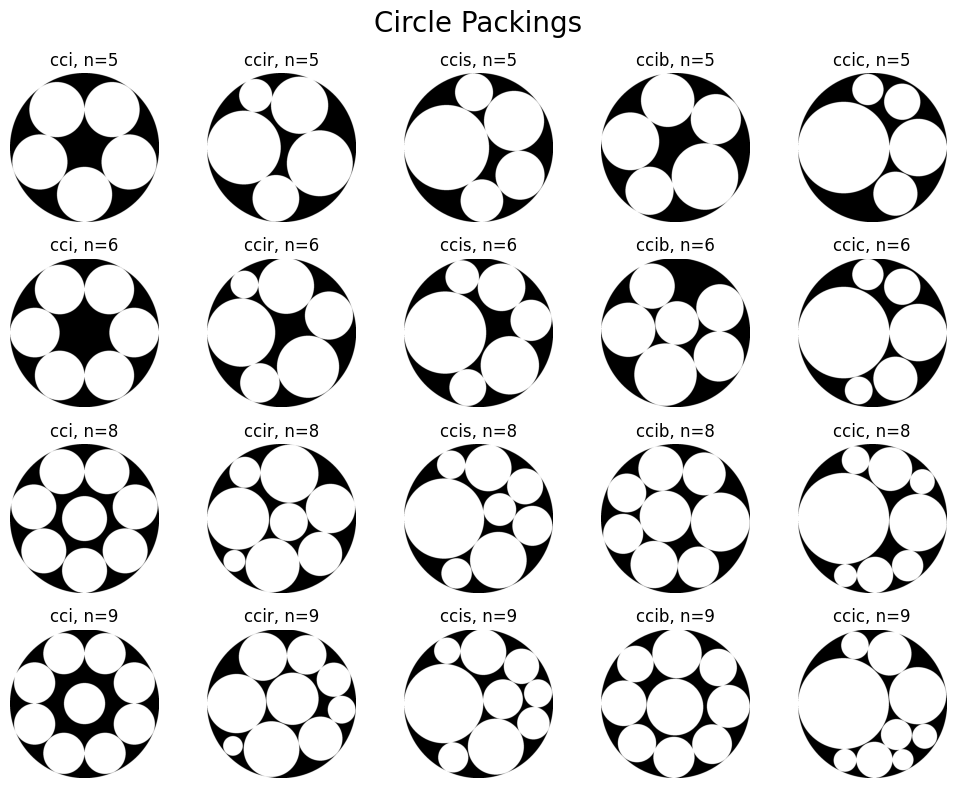

In [24]:
num_circles_list = [5, 6, 8, 9]
image_size = 1024

# Visualize different numbers of circles across rows and different packing types across columns
fig, axes = plt.subplots(4, 5, figsize=(10, 8))
file_path = Path('reports/figures/packings/packings-illustration.png')

for row, num_circles in enumerate(num_circles_list):
    for col, packing_type in enumerate(PACKING_TYPES_DICT):
        # Obtain packing data
        packing_data = get_packing_data(num_circles, packing_type, image_size)
        
        # Create emtpy card
        packing = create_empty_card(image_size)

        # Iteratively draw circles on card
        for circle in range(num_circles):
            center_x, center_y = packing_data['coordinates'][circle]
            radius = packing_data['sizes'][circle] // 2

            draw = ImageDraw.Draw(packing)
            draw.ellipse(
                (center_x - radius, center_y - radius,
                 center_x + radius, center_y + radius
                ), fill=0)

        # Convert to NumPy array
        packing_np = np.array(packing)

        # Make the image fully opaque (i.e., turn transparent background black)
        packing_np[..., 3] = 255

        # Separate color channels and alpha channel
        color_channels = packing_np[..., :3]
        alpha_channel = packing_np[..., 3]

        # Invert color channels
        inverted_color_channels = 255 - color_channels

        # Combine inverted color channels with alpha channel
        packing_np = np.concatenate(
            (inverted_color_channels, alpha_channel[..., np.newaxis]), axis=2
            )
        
        axes[row, col].imshow(packing_np)
        title = f'{packing_type}, n={num_circles}'
        axes[row, col].set_title(title)
        axes[row, col].axis('off')

plt.suptitle('Circle Packings', size=20)
plt.tight_layout()
file_path.parent.mkdir(parents=True, exist_ok=True)
if not file_path.exists():
    _ = plt.savefig(file_path)
plt.show()

### Finite Projective Planes

In the first chapter of this notebook, we have already established that a deck of *Dobble* playing cards corresponds to a finite projective plane, where the order of the latter is one less than the number of symbols on each card. Thus, to create a valid *Dobble* deck (i.e., a set of playing cards such that each pair of cards shares exactly one symbol), we need to compute the so-called *incidence matrix* of its corresponding projective plane. This incidence matrix tells us which points belong to which line (or in *Dobble* terms: which symbol should go on which card).

Since the construction we want to use (called the *vector space construction with finite fields*) to construct finite projective planes only works for orders $n = p^k$ that are prime powers, let's quickly implement **two functions** that we can use to **check whether a given integer is a prime power or not**.

In [25]:
def is_prime(num: float) -> bool:
    """Check if a number is prime.

    Args:
        num (float): The number to be checked.

    Returns:
        bool: True if the number is prime, False otherwise.
    """
    is_integer = isinstance(num, int) or (isinstance(num, float) and num.is_integer())

    if not is_integer or num <= 1:
        return False

    # Check for non-trivial factors
    for i in range(2, int(num ** 0.5) + 1):
        if num % i == 0:
            return False
    return True


def is_prime_power(num: float) -> bool:
    """Check if a number is a prime power.

    Args:
        num (float): The number to be checked.

    Returns:
        bool: True if the number is a prime power, False otherwise.
    """
    is_integer = isinstance(num, int) or (isinstance(num, float) and num.is_integer())

    if not is_integer or num <= 1:
        return False

    # Compute the i-th root of num and check if it's prime
    for i in range(1, int(math.log2(num)) + 1):
        root = num ** (1 / i)
        if root.is_integer() and is_prime(root):
            return True
    return False


Now that we have this, let's implement an algorithm that constructs the incidence matrix for a finite projective plane of order $n = p^k$, with $p$ being a prime number.

**Note**: The function `compute_incidence_matrix` is based on the algorithm presented in the article [The Dobble algorithm](https://mickydore.medium.com/the-dobble-algorithm-b9c9018afc52) by *Micky Dore*.

In [26]:
def compute_incidence_matrix(order: int) -> np.ndarray:
    """Compute the incidence matrix of a finite projective plane with specified order.

    Args:
        order (int): The order of the finite projective plane.

    Returns:
        np.ndarray: The computed incidence matrix.  Rows correspond to lines and columns correspond to points.

    Raises:
        ValueError: If the argument 'order' is not a prime power.

    Example:
        >>> compute_incidence_matrix(2)
        array([[ True,  True,  True, False, False, False, False],
               [ True, False, False,  True,  True, False, False],
               [ True, False, False, False, False,  True,  True],
               [False,  True, False,  True, False,  True, False],
               [False,  True, False, False,  True, False,  True],
               [False, False,  True,  True, False, False,  True],
               [False, False,  True, False,  True,  True, False]])
    """
    if not is_prime_power(order):
        raise ValueError("The 'order' argument must be a prime power.")

    # Number of points/lines of a finite projective plane of order n is given by n^2 + n + 1
    size = order ** 2 + order + 1

    # Preallocate incidence matrix, where rows correspond to lines and columns correspond to points
    incidence_matrix = np.zeros((size, size), dtype=bool)

    # Determine which points are on the first line
    which_line = 0
    which_pts = list(range(order + 1))
    incidence_matrix[which_line, which_pts] = True

    # Determine which points are on the next n lines
    for line in range(order):
        which_line += 1
        # The first n + 1 lines will all share point '0'
        which_pts = [0]
        start = (line + 1) * order + 1
        end = start + order
        which_pts.extend(list(range(start, end)))
        incidence_matrix[which_line, which_pts] = True

    # Determine which points are on the final n^2 lines
    for block in range(order):
        for line in range(order):
            which_line += 1
            which_pts = [block + 1]
            for pt in range(order):
                which_pts.append(order * (pt + 1) + ((block * pt + line) % order) + 1)
            incidence_matrix[which_line, which_pts] = True

    return incidence_matrix


### Dobble Decks

We now have everything that we need to create our own custom *Dobble* decks. Here, we throw everything together into a single function that creates a full set of playing cards. Before we do so, let's quickly implement a function that **generates a single playing card**.

In [27]:
def create_dobble_card(
        scale: float,
        image_size: int,
        packing_type: str,
        emoji_set: str,
        emoji_list: list[str],
        outline_only: bool = False,
        return_pil: bool = True) -> Image.Image | np.ndarray:
    """Create a single Dobble playing card.

    Args:
        scale (float): Determines to what extent the emoji should fill the inscribed circle.
        image_size (int): The size of the square image in pixels.
        packing_type (str): The type of circle packing.
        emoji_set (str): The name of the set of emojis (e.g., 'classic-dobble')
        emoji_list (list[str]): The list of names of the emojis to be placed on the playing card.
        outline_only (bool): Whether to load the outline-only version of the emoji.  Defaults to False.
        return_pil (bool): Whether to return a PIL Image (True) or a NumPy array (False).  Defaults to True.

    Returns:
        Image.Image or np.ndarray: The generated image of a Dobble playing card.
    """
    dobble_card = create_empty_card(image_size)
    num_emojis = len(emoji_list)
    packing_data = get_packing_data(num_emojis, packing_type, image_size)

    # Place emojis on card
    for count, emoji_name in enumerate(emoji_list):
        emoji_image = rescale_emoji(load_emoji(emoji_set, emoji_name, outline_only), scale=scale)
        emoji_size = packing_data['sizes'][count]
        emoji_center = packing_data['coordinates'][count]
        rotation_angle = random.randint(0, 359)
        dobble_card = place_emoji(dobble_card, emoji_image, emoji_size, emoji_center, rotation_angle)

    return dobble_card if return_pil else np.array(dobble_card)


To make sure that this function works as expected, let's **visualize a few custom playing cards**.

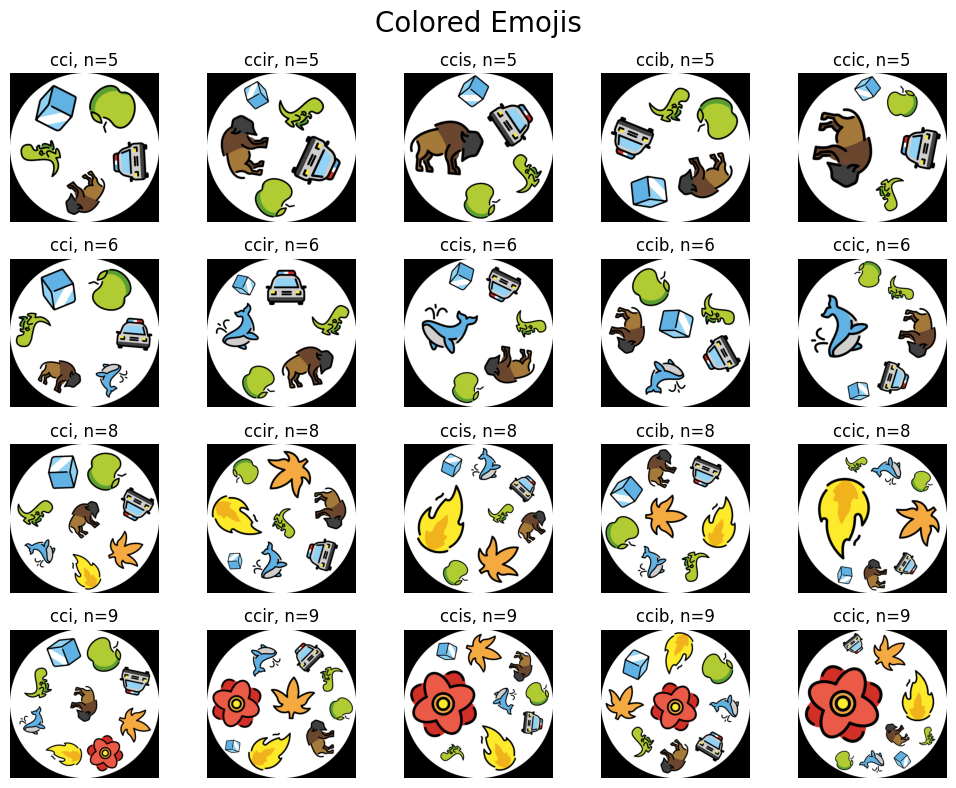

In [28]:
scale = 0.9
card_size = 1024
emoji_set = 'classic-dobble'
emoji_lists = [
    ['ice', 'green-apple', 't-rex', 'oncoming-police-car', 'bison'],
    ['ice', 'green-apple', 't-rex', 'oncoming-police-car', 'bison', 'spouting-whale'],
    ['ice', 'green-apple', 't-rex', 'oncoming-police-car', 'bison', 'spouting-whale', 'maple-leaf', 'fire'],
    ['ice', 'green-apple', 't-rex', 'oncoming-police-car', 'bison', 'spouting-whale', 'maple-leaf', 'fire', 'rosette']
    ]

# Visualize different numbers of symbols per card across rows and different packing types across columns
fig, axes = plt.subplots(4, 5, figsize=(10, 8))
file_path = Path('reports/figures/packings/packings-with-emojis.png')

for row, emoji_list in enumerate(emoji_lists):
    for col, packing_type in enumerate(PACKING_TYPES_DICT):
        dobble_card_np = create_dobble_card(
            scale, card_size, packing_type, emoji_set, emoji_list, return_pil=False
            )
        
        # Make the image fully opaque (i.e., turn transparent background black)
        dobble_card_np[..., 3] = 255
        
        axes[row, col].imshow(dobble_card_np)
        title = f'{packing_type}, n={len(emoji_list)}'
        axes[row, col].set_title(title)
        axes[row, col].axis('off')

plt.suptitle('Colored Emojis', size=20)
plt.tight_layout()
if not file_path.exists():
    _ = plt.savefig(file_path)
plt.show()

Also, let's see what it looks like if we only use the **outlined emojis**.

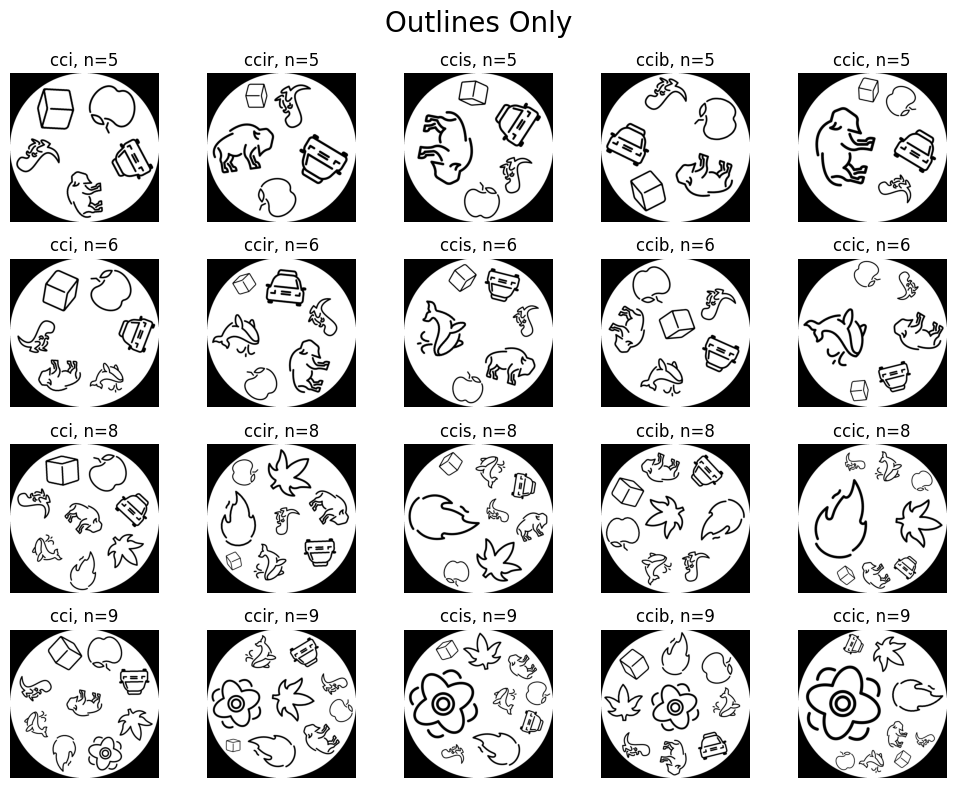

In [29]:
# Visualize different numbers of symbols per card across rows and different packing types across columns
fig, axes = plt.subplots(4, 5, figsize=(10, 8))

for row, emoji_list in enumerate(emoji_lists):
    for col, packing_type in enumerate(PACKING_TYPES_DICT):
        dobble_card_np = create_dobble_card(
            scale, card_size, packing_type, emoji_set, emoji_list, return_pil=False, outline_only=True
            )
        
        # Make the image fully opaque (i.e., turn transparent background black)
        dobble_card_np[..., 3] = 255
        
        axes[row, col].imshow(dobble_card_np)
        title = f'{packing_type}, n={len(emoji_list)}'
        axes[row, col].set_title(title)
        axes[row, col].axis('off')

plt.suptitle('Outlines Only', size=20)
plt.tight_layout()
plt.show()

In [30]:
DATA_DIR = Path('data/processed')

Next, let's think for a moment about the **parameters** that we want to be able to control when creating a new deck of playing cards:

* `emoji_set` **Which set of emojis** do we want to use?
* `num_emojis` **How many emojis** do we want **on each card**? Remember that this number needs to be equal to $p^k + 1$ with $p$ being prime (i.e., an integer that immediately follows a prime power).
* `scale` How do we want to **rescale the emoji images** before placing them on the cards? 
* `image_size` **How large** (in pixels) should each (card) image be?
* `deck_name` What do we want to call our newly created deck? This will also serve as the **name of the subdirectory** of the directory, where we will store the images.
* `outline_only` Do we want to use the **colored versions** of the emojis **or** just their **outlines**?
* `packing_type` Do we want to use one **type of circle packing** for all cards or do we want to choose the packing type randomly for each card to have greater variability between cards?

Finally, here is an **outline of the individual steps** we need to take to create our custom deck of playing cards:

1. Using the `deck_name` parameter, create a subdirectory to store the generated images.
2. Compute the incidence matrix of the finite projective plane of the appropriate order (Remember: The order of the projective plane is one less than the number of symbols on each card!). We make use of the `compute_incidence_matrix` function to achieve this.
3. Read in the names of all the emojis available in the specified `emoji_set`. We use the `get_emoji_names` function to do so.
    * Make sure that there are enough emojis available in this set! The number of distinct emojis needed in total is derived from the `num_emojis`. If there aren't enough, throw an error. If there are too many, choose a random subset of the appropriate size.
4. Set up a CSV file that will store all the necessary information to create the ground-truth labels later on (i.e., which is the common symbol between any pair of cards?).
5. Finally, create the playing cards one by one. This is done as follows:
    * The incidence matrix generated by the `compute_incidence_matrix` function tells us which emojis need to be placed on which card (i.e., the entries in the $i$-th row determine the emojis that need to be placed on the $i$-th playing card).
    * Select the names of the corresponding emojis from the `emoji_names` list that we created earlier using the `get_emoji_names` function.
    * Shuffle this list to randomly place the emojis on the card and create the playing card with the `create_dobble_card` function.
    * Finally, append all the relevant information about the card that was just generated to the CSV file created earlier.

In [31]:
def create_dobble_deck(
        emoji_set: str,
        num_emojis: int,
        scale: float,
        image_size: int,
        deck_name: str,
        outline_only: bool = False,
        packing_type: str = None) -> tuple[str, str]:
    """Create a full set of playing cards (i.e., generate and save images).

    Args:
        emoji_set (str): The name of the set of emojis (e.g., 'classic-dobble') to use.
        num_emojis (int): The number of emojis to place on each card.
        scale (float): Determines to what extent the emoji should fill the inscribed circle.
        image_size (int): The size of each square image (of a single playing card) in pixels.
        deck_name (str): The name of the deck.  Will also be used to create the subdirectory
            that stores all the generated images.
        outline_only (bool): Whether to generate playing cards with outline-only emojis.  Defaults to False.
        packing_type (str): The type of packing to use for placing emojis on the cards.
            If not provided, a packing type is randomly chosen for each card.  Defaults to None.

    Returns:
        tuple[str, str]: A tuple containing the file paths to the generated CSV files that store all
            information about the playing cards ('deck.csv') as well as the emoji labels ('emoji_labels.csv').
    """
    deck_dir = DATA_DIR / deck_name  # directory to store the images
    csv_dir = deck_dir / 'csv'  # directory to store all the information about the deck

    # If the 'csv_dir' already exists (i.e., the deck has already been created),
    # we simply return the two CSV files that would be created by this function
    if csv_dir.exists():
        deck_csv = csv_dir / 'deck.csv'
        emoji_labels_csv = csv_dir / 'emoji_labels.csv'
        return deck_csv, emoji_labels_csv
    else:
        csv_dir.mkdir(parents=True, exist_ok=True)

    # Compute incidence matrix of corresponding finite projective plane
    order = num_emojis - 1
    incidence_matrix = compute_incidence_matrix(order)

    # The number of cards in a deck is given by n^2 + n + 1, with n + 1 = # symbols on each card
    # NOTE: Remember that there are as many distinct symbols in a deck as there are cards
    num_cards = order ** 2 + order + 1

    # Read in the names of all emojis in the specified 'emoji_set'
    emoji_names = get_emoji_names(emoji_set, outline_only)

    # Check if there are enough emojis in the specified subdirectory
    num_emojis_available = len(emoji_names)
    if num_emojis_available < num_cards:
        raise ValueError('Not enough emojis in the specified set to create the Dobble deck.')
    elif num_emojis_available > num_cards:
        # If there are more emojis than we need, we randomly choose a subset of the appropriate size
        emoji_names = random.sample(emoji_names, num_cards)

    # Create CSV file to store information about the individual emojis and their corresponding labels
    emoji_labels = pd.DataFrame({'EmojiName': emoji_names, 'EmojiLabel': range(len(emoji_names))})
    emoji_labels_csv = csv_dir / 'emoji_labels.csv'
    emoji_labels.to_csv(emoji_labels_csv, index=False)

    # If no 'packing_type' was provided initially, choose one randomly
    # each time from the 'PACKING_TYPES_DICT' dictionary
    choose_randomly = packing_type is None

    # Create CSV file to store information about the individual cards
    deck_csv = csv_dir / 'deck.csv'
    with open(deck_csv, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(
            ['FilePath'] + ['PackingType'] + ['Emoji' + str(i + 1) for i in range(num_emojis)]
            )

    # Create playing cards one-by-one using the incidence matrix to decide which emojis to put on which card
    # NOTE: len(a) is equivalent to np.shape(a)[0] for N-D arrays with N>=1.
    for card in range(len(incidence_matrix)):
        # Find the emojis that are to be placed on the card
        which_emojis = np.where(incidence_matrix[card])[0]
        emoji_list = [emoji_names[idx] for idx in which_emojis]
        random.shuffle(emoji_list)

        # If no 'packing_type' was provided initially, choose one randomly
        # from the 'PACKING_TYPES_DICT' dictionary
        if choose_randomly:
            packing_type = random.choice(list(PACKING_TYPES_DICT.keys()))

        # Create playing card and save in directory
        dobble_card = create_dobble_card(
            scale,
            image_size,
            packing_type,
            emoji_set,
            emoji_list,
            outline_only
            )
        file_name = f'{deck_name}_{card + 1:03d}.png'
        file_path = deck_dir / file_name
        dobble_card.save(file_path)

        # Write card information to the CSV file
        with open(deck_csv, 'a', newline='') as f:
            writer = csv.writer(f)
            writer.writerow([file_path] + [packing_type] + emoji_list)

    return deck_csv, emoji_labels_csv


Let's test this function and create and then visualize our first custom deck of *Dobble* playing cards!

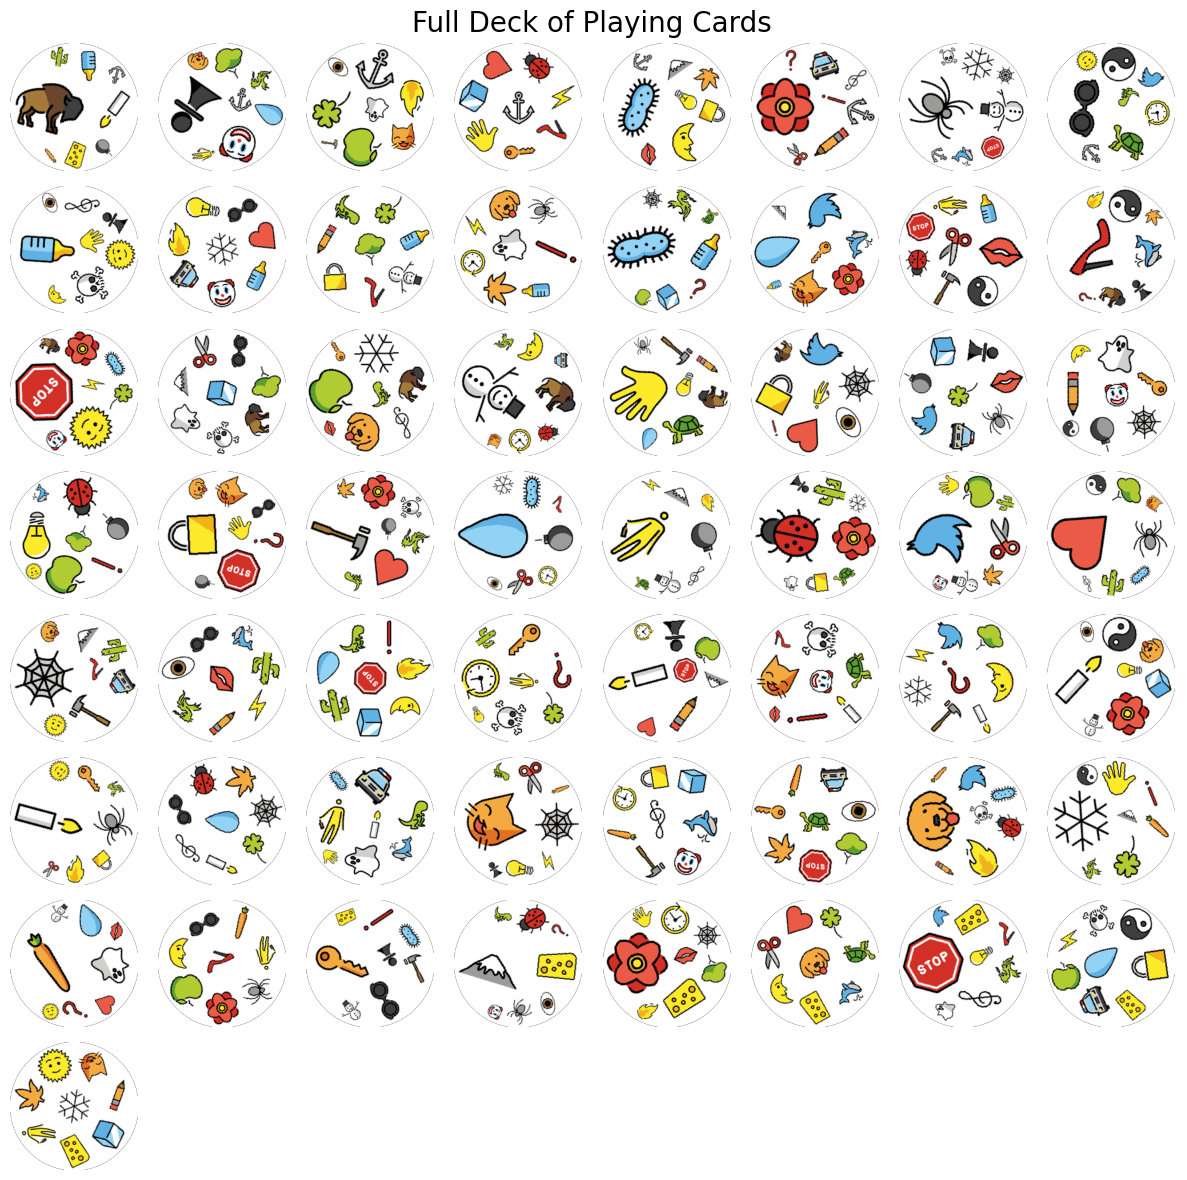

In [32]:
# We set a random seed for reproducibility
random.seed(33)

emoji_set = 'classic-dobble'
num_emojis = 8
image_size = 224
deck_name = 'classic-dobble'

deck_csv, emoji_labels_csv = create_dobble_deck(
    emoji_set,
    num_emojis,
    scale,
    image_size,
    deck_name
    )

# Set up plot
fig, axes = plt.subplots(8, 8, figsize=(12, 12))

# Extract file paths to images
file_path = Path('reports/figures/cards/classic-dobble-deck.png')
image_paths = pd.read_csv(deck_csv)['FilePath'].values.tolist()

# Display playing cards
for count, ax in enumerate(axes.flat):
    if count < len(image_paths):
        image = Image.open(image_paths[count])
        image_np = np.array(image)
        ax.imshow(image_np)
        ax.axis('off')
    else:
        ax.axis('off')

plt.suptitle('Full Deck of Playing Cards', size=20)
plt.tight_layout()
file_path.parent.mkdir(parents=True, exist_ok=True)
if not file_path.exists():
    _ = plt.savefig(file_path)
plt.show()

### Pairs of Cards

When training networks, we want to pass images that display pairs of playing cards so that the network has to find the unique emoji shared by the two playing cards in the image. To achieve this, we will create a square image of a uniformly colored background, divide it into four quadrants of equal size, and then place two playing cards into two of these quadrants.

First, let's write a function that computes the coordinates of where the playing cards need to be positioned based on the quadrant that they are supposed to be placed in.

In [33]:
def compute_quadrant_coordinates(
        quadrant: int,
        image_size: int) -> tuple[int, int]:
    """Compute the coordinates of a specified quadrant within a square image.

    Args:
        quadrant (int): The quadrant number, ranging from 1 to 4.
        image_size (int): The size of the square image.

    Returns:
        tuple[int, int]: The upper left coordinates (x, y) of the specified quadrant within the square image.

    Raises:
        ValueError: If an invalid 'quadrant' (number) is provided.
    """
    quadrant_size = image_size // 2
    
    if quadrant == 1:  # upper right
        coordinates = (quadrant_size, 0)
    elif quadrant == 2:  # upper left
        coordinates = (0, 0)
    elif quadrant == 3:  # lower left
        coordinates = (0, quadrant_size)
    elif quadrant == 4:  # lower right
        coordinates = (quadrant_size, quadrant_size)
    else:
        raise ValueError('Invalid quadrant. Please provide a value from 1 to 4.')

    return coordinates


Next, we write a function that returns the desired **images of pairs of cards**.

In [34]:
def create_tile_image(
        image1: Image.Image,
        image2: Image.Image,
        quadrants: tuple[int, int],
        bg_color: tuple[int, int, int] = None,
        return_pil: bool = True) -> Image.Image | np.ndarray:
    """Create a tile image by combining two square images based on the specified quadrants.

    Args:
        image1 (Image.Image): The first input image to place on the tile image.
        image2 (Image.Image): The second input image to place on the tile image.
        quadrants (tuple[int, int]): Tuple of integers from 1 to 4 representing the quadrants in which
            the two images will be placed.
        bg_color (tuple[int, int, int]): The RGB color tuple for the background color.  Defaults to None.
        return_pil (bool): Whether to return a PIL Image (True) or a NumPy array (False).  Defaults to True.

    Returns:
        Image.Image or np.ndarray: The generated tile image.

    Raises:
        ValueError: If two identical quadrants are provided.
    """
    if quadrants[0] == quadrants[1]:
        raise ValueError('Two identical quadrants provided. Images would overlap.')

    tile_image_size = 2 * image1.width

    # Choose random background color if 'bg_color' was not specified
    if bg_color is None:
        bg_color = tuple(np.random.randint(0, 256, size=3, dtype=np.uint8))

    tile_image = Image.new('RGBA', (tile_image_size, tile_image_size), bg_color)

    image1_pos = compute_quadrant_coordinates(quadrants[0], tile_image_size)
    image2_pos = compute_quadrant_coordinates(quadrants[1], tile_image_size)

    tile_image.paste(image1, image1_pos, mask=image1)
    tile_image.paste(image2, image2_pos, mask=image2)

    return tile_image if return_pil else np.array(tile_image)


Let's make sure that this function works as expected. For each possible combination of quadrants, we choose two arbitrary cards each from our set of playing cards that we have already created and then arrange them into a single image using the `create_tile_image` function.

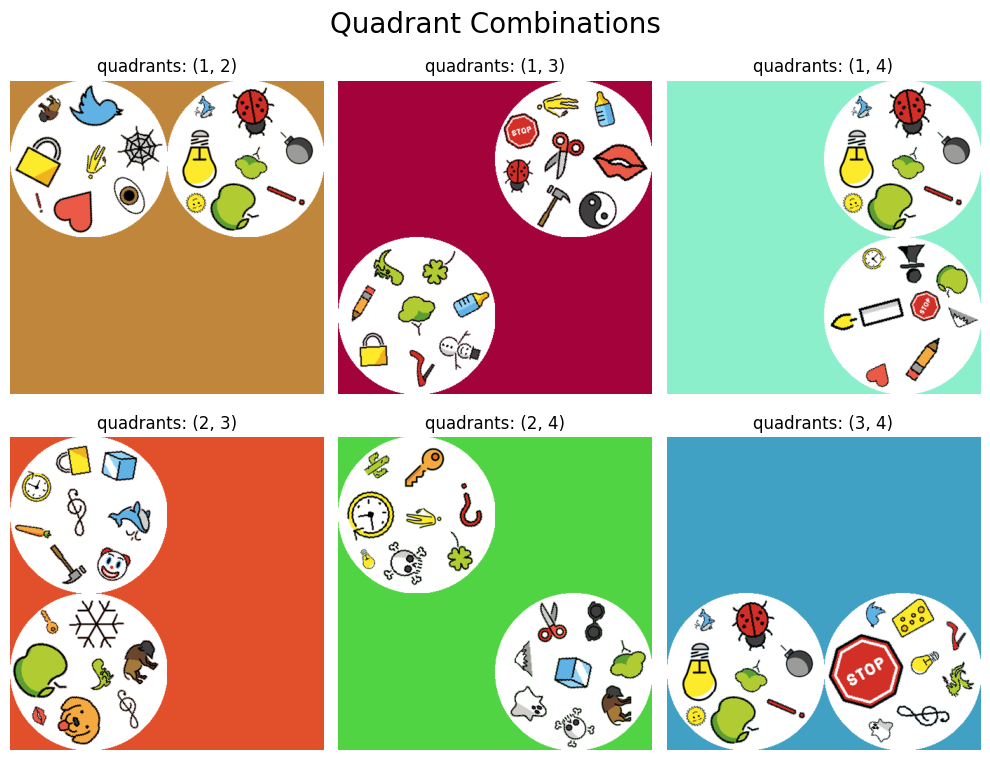

In [35]:
# NOTE: The file paths to the images of our playing cards are still stored in the 'image_paths' variable!
num_cards = len(image_paths)

fig, axes = plt.subplots(2, 3, figsize=(10, 8))
axes = axes.flatten()
count = 0

# Again, we set random seeds for reproducibility
random.seed(41)  # identical playing cards
rng = np.random.seed(41)  # identical background colors

for pos1 in range(1, 4):
    for pos2 in range(pos1 + 1, 5):
        image1_idx, image2_idx = random.sample(range(0, num_cards), 2)
        image1 = Image.open(image_paths[image1_idx])
        image2 = Image.open(image_paths[image2_idx])
        quadrants = (pos1, pos2)
        tile_image_np = create_tile_image(image1, image2, quadrants, return_pil=False)

        ax = axes[count]
        count += 1
        
        ax.imshow(tile_image_np)
        ax.set_title(f'quadrants: {quadrants}')
        ax.axis('off')

plt.suptitle('Quadrant Combinations', size=20)
plt.tight_layout()
plt.show()

## Setting up a Deep Learning Pipeline

We can now create custom data (images of custom *Dobble* playing cards) to use in our deep learning project. Next, let's prepare all the necessary tools that we need to set up our deep learning pipeline (e.g., dataset generation, training routines, etc.).


### Generating Datasets

So far, when we create a new set of playing cards (i.e., images), we automatically generate two CSV files: one containing general information about the deck (e.g., where are the images stored, which emojis are placed on which card) and one containing a mapping between integer labels and emoji names. What we also need is a **CSV file that contains all possible pairs of playing cards**. This is exactly what we'll take care of next.

In [36]:
def pair_up_cards(
        deck_csv: str,
        emoji_labels_csv: str) -> str:
    """Create a CSV file containing all possible combinations of playing cards in a Dobble deck.

    Args:
        deck_csv (str): The file path to the CSV file generated by the 'create_dobble_deck' function.
        emoji_labels_csv (str): The file path to the CSV file generated by the 'create_dobble_deck' function.

    Returns:
        str: The file path to the created CSV file 'pairs.csv'.
    """
    # Check if 'pairs' CSV has already been created
    csv_dir = Path(deck_csv).parent
    pairs_csv = csv_dir / 'pairs.csv'
    
    if pairs_csv.exists():
        return pairs_csv

    # Read the card information from the 'deck_csv' file into a list of lists,
    # where inner lists correspond to rows of the CSV file
    with open(deck_csv, 'r') as f:
        reader = csv.reader(f)
        next(reader)  # Skip header
        deck_info = list(reader)

    # Read the mapping information (i.e., emoji names to integers) from the CSV file 'emoji_labels_csv'
    emoji_labels_df = pd.read_csv(emoji_labels_csv)

    # Generate all combinations of pairs of cards (ignoring the order of cards)
    card_pairs = itertools.combinations(deck_info, 2)

    with open(pairs_csv, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(['Card1Path', 'Card2Path', 'CommonEmojiLabel'])

        # Iterate over each pair of cards
        for pair in card_pairs:
            card1_path = pair[0][0]  # Extract file path of the first card
            card2_path = pair[1][0]  # Extract file path of the second card
            emojis1 = pair[0][2:]    # Extract names of emojis that are placed on the first card
            emojis2 = pair[1][2:]    # Extract names of emojis that are placed on the second card

            # Find the common emoji between the two cards
            common_emoji = (set(emojis1) & set(emojis2)).pop()
            common_emoji_label = emoji_labels_df.loc[
                emoji_labels_df['EmojiName'] == common_emoji, 'EmojiLabel'
                ].iloc[0]

            # Write data to CSV file
            writer.writerow([card1_path, card2_path, common_emoji_label])

    return pairs_csv


Let's create the **CSV file that contains all the possible pairs of cards** of our recently created Dobble deck. If everything works as expected, this CSV file should contain $(57 * 56) / 2 = 1596$ entries (not counting the header).

In [37]:
pairs_csv = pair_up_cards(deck_csv, emoji_labels_csv)

Next, we simply combine the two functions `create_dobble_deck` and `pair_up_cards` into a single function that (if not done already) creates a full deck of custom *Dobble* playing cards and also creates all the necessary CSV files (deck information, emoji labels mapping, and pairs of cards) in one go.

In [38]:
def prepare_dobble_dataset(
        emoji_set: str,
        num_emojis: int,
        scale: float,
        image_size: int,
        deck_name: str,
        outline_only: bool = False,
        packing_type: str = None) -> tuple[str, str, str]:
    """Prepare a full dataset of playing cards (i.e., generate and save images, pair up playing cards).

    Args:
        emoji_set (str): The name of the set of emojis (e.g., 'classic-dobble') to use.
        num_emojis (int): The number of emojis to place on each card.
        scale (float): Determines to what extent the emoji should fill the inscribed circle.
        image_size (int): The size of each square image (of a single playing card) in pixels.
        deck_name (str): The name of the deck.  Will also be used to create the subdirectory
            that stores all the generated images.
        outline_only (bool): Whether to generate playing cards with outline-only emojis.  Defaults to False.
        packing_type (str): The type of packing to use for placing emojis on the cards.
            If not provided, a packing type is randomly chosen for each card.  Defaults to None.

    Returns:
        tuple[str, str, str]: A tuple containing the file paths to the generated CSV files that store all
            information about the playing cards ('deck.csv'), the emoji labels ('emoji_labels.csv'),
            and all pairs of cards ('pairs.csv'), in that order.
    """
    deck_csv, emoji_labels_csv = create_dobble_deck(
        emoji_set, num_emojis, scale, image_size, deck_name, outline_only, packing_type
        )
    pairs_csv = pair_up_cards(deck_csv, emoji_labels_csv)

    return deck_csv, emoji_labels_csv, pairs_csv


As always, let's double-check that this function works as expected!

In [39]:
emoji_set = 'classic-dobble'
num_emojis = 8
scale = 0.9
image_size = 224
deck_name = 'classic-dobble'

csv_files = prepare_dobble_dataset(
    emoji_set, num_emojis, scale, image_size, deck_name
    )

for csv_file in csv_files:
    print(csv_file)

data/processed/classic-dobble/csv/deck.csv
data/processed/classic-dobble/csv/emoji_labels.csv
data/processed/classic-dobble/csv/pairs.csv


The `pairs_csv` file that we created earlier (which is also contained as the last entry in the `csv_files` tuple) describes the full dataset that we can work with. For training purposes, we want to **split this dataset into three subsets** that can be used for training, validation, and testing.

In [40]:
def split_dataset(
        dataset_csv: str,
        train_ratio: float,
        val_ratio: float) -> tuple[str, str, str]:
    """Split a dataset given by a CSV file into three subsets: train, validation, and test.

    Args:
        dataset_csv (str): Path to the original CSV file.
        train_ratio (float): Proportion of the dataset for the training set (between 0 and 1).
        val_ratio (float): Proportion of the dataset for the validation set (between 0 and 1).

    Returns:
        tuple[str, str, str]: A tuple containing the file paths for the train, validation, and test CSV files.

    Raises:
        ValueError: If the sum of 'train_ratio' and 'val_ratio' is greater than 1.
    """
    if train_ratio + val_ratio > 1:
        raise ValueError("The sum of 'train_ratio' and 'val_ratio' cannot exceed 1.")

    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(dataset_csv)

    # Randomly shuffle the DataFrame's rows
    df = df.sample(frac=1, random_state=42).reset_index(drop=True)

    # Calculate the number of samples for each subset
    num_all = len(df)
    num_train = int(num_all * train_ratio)
    num_val = int(num_all * val_ratio)

    # Split into train, validation, and test subsets
    train_df = df[:num_train]
    val_df = df[num_train:num_train + num_val]
    test_df = df[num_train + num_val:]

    # Extract the directory path of the 'dataset_csv' file and construct file paths for the output CSV files
    dir_path = Path(dataset_csv).parent
    train_csv = dir_path / 'train.csv'
    val_csv = dir_path / 'val.csv'
    test_csv = dir_path / 'test.csv'

    # Write the subsets to separate CSV files
    train_df.to_csv(train_csv, index=False)
    val_df.to_csv(val_csv, index=False)
    test_df.to_csv(test_csv, index=False)

    return train_csv, val_csv, test_csv


Let's test this function to see if it works as expected.

In [41]:
train_ratio = 0.7  # 70 % of the data will be used for training purposes
val_ratio = 0.15  # 15 % of the data will be used for validation purposes

dataset_csvs = split_dataset(pairs_csv, train_ratio, val_ratio)

for dataset_csv in dataset_csvs:
    print(dataset_csv)

data/processed/classic-dobble/csv/train.csv
data/processed/classic-dobble/csv/val.csv
data/processed/classic-dobble/csv/test.csv


At this point, we have prepared all of the data so that it can be used to train a network. Next, we define a **custom dataset class** that we'll name `DobbleDataset`. This class takes as input the path to the CSV file holding the dataset information (e.g., the `train_csv`, `val_csv`, or `test_csv` file paths generated by the `split_dataset` function), a background color for the tile images of pairs of cards, a transform that is applied to the images of the individual playing cards, and two transforms that are sequentially applied to the final tile image. Note that the last four parameters are optional. If any transform is not provided, then the corresponding transformation is simply not performed. If the background color is not supplied, it is chosen randomly by the `create_tile_image` function.

In [42]:
class DobbleDataset(torch.utils.data.Dataset):
    """Dataset class for the Dobble game, containing pairs of card images and corresponding common emoji labels.

    Args:
        dataset_csv (str): The path to the CSV file containing information about the dataset (i.e., pairs of cards and
            label of common emoji).
        bg_color (tuple[int, int, int]): The RGB color tuple for the background color of the tile images.
            Defaults to None.
        individual_transform (transforms.Compose): A composition of transforms to be applied to the individual card
            images.  Defaults to None.
        tile_transform (transforms.Compose): A composition of transforms to be applied to the tile images.
            Defaults to None.
        preprocess (transforms.Compose): A composition of transforms to be applied to the final images (i.e., after the
            'tile_transform' has been applied).  Defaults to None.

    Attributes:
        image_paths (pd.DataFrame): A Pandas DataFrame containing the paths to the images of the two cards in each
            pair of cards.
        labels (pd.Series): A Pandas Series containing the labels of the common emoji for each pair of cards.
        bg_color (tuple[int, int, int]): The RGB color tuple for the background color of the tile images.
        individual_transform (transforms.Compose): A composition of transforms to be applied to the individual card
            images.
        tile_transform (transforms.Compose): A composition of transforms to be applied to the tile images.
        preprocess (transforms.Compose): A composition of transforms to be applied to the final images (i.e., after the
            'tile_transform' has been applied).

    Example:
        >>> dataset = DobbleDataset(
                dataset_csv='data/processed/classic-dobble/csv/train.csv',
                individual_transform=transforms.Compose([
                    transforms.RandomRotation(30),
                    transforms.RandomHorizontalFlip()
                    ]),
                tile_transform=transforms.ColorJitter(
                    brightness=0.2,
                    contrast=0.2,
                    saturation=0.2,
                    hue=0.1
                    ),
                preprocess=transforms.Compose([
                    transforms.Resize((224, 224)),
                    transforms.ToImage(),
                    transforms.ToDtype(torch.float32, scale=True)
                    ])
                )
        >>> len(dataset)
        57
        >>> image, label = dataset[0]
        >>> image.shape
        torch.Size([3, 224, 224])
        >>> label
        53
    """
    def __init__(
            self,
            dataset_csv: str,
            bg_color: tuple[int, int, int] = None,
            individual_transform: transforms.Compose = None,
            tile_transform: transforms.Compose = None,
            preprocess: transforms.Compose = None) -> None:
        self.image_paths = pd.read_csv(dataset_csv)[['Card1Path', 'Card2Path']]
        self.labels = pd.read_csv(dataset_csv)['CommonEmojiLabel']
        self.bg_color = bg_color
        self.individual_transform = individual_transform
        self.tile_transform = tile_transform
        self.preprocess = preprocess

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx: int) -> tuple[torch.Tensor, int]:
        card1_path = self.image_paths.loc[idx, 'Card1Path']
        card2_path = self.image_paths.loc[idx, 'Card2Path']
        card1_image = Image.open(card1_path)
        card2_image = Image.open(card2_path)

        # Apply individual transforms to the card images if provided
        if self.individual_transform:
            card1_image = self.individual_transform(card1_image)
            card2_image = self.individual_transform(card2_image)

        card1_quadrant, card2_quadrant = random.sample(range(1, 5), 2)
        image = create_tile_image(
            card1_image, card2_image, (card1_quadrant, card2_quadrant),
            self.bg_color
            ).convert('RGB')

        # Apply tile transform to the tile image if provided
        if self.tile_transform:
            image = self.tile_transform(image)

        # Apply preprocessing to obtain final image
        if self.preprocess:
            image = self.preprocess(image)

        label = self.labels.iloc[idx]

        return image, label


The `label` that is returned by the `__getitem__` method of the `DobbleDataset` class is an integer from 0 to the number of emojis in the *Dobble* deck (which coincides with the total number of playing cards) minus 1. It will be convenient for us to translate this integer back to the name of the emoji that it corresponds to. To achieve this, we write a little helper function that takes as input the `emoji_labels_csv` file generated by the `create_dobble_deck` and returns a dictionary mapping integer labels to emoji names.

In [43]:
def create_labels_dict(emoji_labels_csv: str) -> dict[int, str]:
    """Create a dictionary mapping emoji labels (integers starting from 0) to their corresponding names.

    Args:
        emoji_labels_csv (str): The file path to the CSV file containing emoji labels and names.

    Returns:
        dict: A dictionary mapping emoji labels to names.
    """
    emoji_labels_df = pd.read_csv(emoji_labels_csv)
    labels_dict = dict(zip(emoji_labels_df['EmojiLabel'], emoji_labels_df['EmojiName']))

    return labels_dict


Let's create our `labels_dict` and print its first 10 entries.

In [44]:
labels_dict = create_labels_dict(emoji_labels_csv)

for idx in range(10):
    print(f'{idx}: {labels_dict[idx]}')

0: anchor
1: baby-bottle
2: bison
3: bomb
4: cactus
5: candle
6: carrot
7: cheese-wedge
8: chess-pawn
9: clown-face


### Utility Functions

Before we move on to learning rate schedules as well as training and testing routines, we implement a few utility functions that we'll be using later on.

We start by defining our custom `accuracy` function, which gives us slightly more flexibility when **computing the accuracy of a model's predictions** compared to just calculating the fraction of samples the model predicted correctly.

In [45]:
def accuracy(
        output: torch.Tensor,
        target: torch.Tensor,
        top_k: tuple[int, ...] = (1,)) -> list[torch.Tensor]:
    """Calculate the accuracy of a model's output predictions.

    Args:
        output (torch.Tensor): Model's output tensor.
        target (torch.Tensor): Target tensor containing the ground truth labels.
        top_k (tuple[int, ...]): Tuple of integers representing the top-k values to consider for accuracy calculation.
            Defaults to (1,).

    Returns:
        list[torch.Tensor]: A list of torch.Tensor objects representing accuracy values for
            each top-k value specified.

    Note:
        The top-k accuracy considers whether the correct label is among the top-k predicted labels.

    Example:
        >>> output = torch.tensor([[0.2, 0.3, 0.5], [0.7, 0.1, 0.2]])
        >>> target = torch.tensor([1, 1])
        >>> accuracy(output, target, top_k=(1, 2, 3))
        [tensor([0.]), tensor([50.]), tensor([100.])]
    """
    with torch.no_grad():
        max_k = max(top_k)  # max 'top_k' value
        batch_size = target.size(0)  # number of labels (= number of samples in the batch)

        # Compute indices of top k values for each prediction
        _, prediction = output.topk(max_k, 1, largest=True, sorted=True)
        prediction = prediction.t()

        # Check whether predictions match target (i.e., ground truth labels)
        correct = prediction.eq(target.view(1, -1).expand_as(prediction))

        result = []
        for k in top_k:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            result.append(correct_k.mul_(100. / batch_size))

        return result


The next function allows us to **re-print the training logs** that were initially printed out during training and collected in a `train_logs` dictionary.

In [46]:
def reprint_logs(
        train_logs: dict[str, list[float]],
        start_after: int = 0,
        print_freq: int = None) -> None:
    """Re-print training logs.

    Args:
        train_logs (dict[str, list[float]]): A dictionary containing training logs.
        start_after (int): The epoch after which to start re-printing the training logs.  Defaults to 0.
        print_freq (int): Frequency (in number of epochs) at which to re-print information about
            the training progress.  Defaults to None.

    Returns:
        None
    """
    num_epochs = len(train_logs['train_loss'])

    if print_freq is None:
        print_freq = num_epochs // 10

    for epoch in range(start_after, num_epochs):
        if (epoch + 1) % print_freq == 0:
            print('Epoch [{:03d}/{:03d}]   Train   Loss={:.4f}   Acc={:.2f}    Val   Loss={:.4f}   Acc={:.2f}'.format(
                epoch + 1,                        # epoch number
                num_epochs,                       # total number of epochs
                train_logs['train_loss'][epoch],  # loss (training)
                train_logs['train_acc'][epoch],   # accuracy (training)
                train_logs['val_loss'][epoch],    # loss (validation)
                train_logs['val_acc'][epoch]      # accuracy (validation)
                ))


We now implement a function that **visualizes the results** (i.e., loss and accuracy during training and validation) **of training** a network.

In [47]:
def plot_loss_and_accuracy(
        train_logs: dict[str, list[float]],
        save_plot: bool = False,
        figure_title: str = None) -> None:
    """Plot the loss and accuracy curves for training and validation.

    Args:
        train_logs (dict[str, list[float]]): A dictionary containing training logs.
        save_plot (bool): Whether to save the generated plot.  Defaults to False.
        figure_title (str): The title of the saved figure.  Defaults to None.

    Returns:
        None
    """
    num_epochs = len(train_logs['train_loss'])
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    for i, ax in enumerate(axes):
        ax.plot(range(1, num_epochs + 1), train_logs['train_loss'] if i == 0 else train_logs['train_acc'])  # training
        ax.plot(range(1, num_epochs + 1), train_logs['val_loss'] if i == 0 else train_logs['val_acc'])  # validation
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Loss' if i == 0 else 'Accuracy (in %)')
        ax.set_title('Loss' if i == 0 else 'Accuracy')
        ax.legend(['Training', 'Validation'])
        ax.grid(which='major', color='#DDDDDD')
        ax.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.9)
        ax.minorticks_on()

    plt.suptitle('Training Results', size=20)
    plt.tight_layout()

    if save_plot:
        file_name = figure_title if figure_title else 'training-results.png'
        try:
            plt.savefig(Path('reports/figures/results', file_name))
            print('Plot saved successfully.')
        except Exception as e:
            print(f'Error while saving the plot: {e}')

    plt.show()


Next, `calculate_mean_std` **computes the mean and standard deviation per color channel of a given dataset** (provided through a dataloader).

In [48]:
def calculate_mean_std(loader: torch.utils.data.DataLoader) -> tuple[list[float], list[float]]:
    """Calculate the mean and standard deviation of pixel values per channel from a given dataloader.

    Args:
        loader (torch.utils.data.DataLoader): A dataloader that provides batches of images.

    Returns:
        tuple[list[float], list[float]]: A tuple containing the mean and standard deviations of each channel.
    """
    with torch.no_grad():
        running_sum = torch.zeros(3)  # per channel
        running_squared_sum = torch.zeros(3)  # per channel
        total_pixels = 0  # per channel

        for images, _ in loader:
            b, c, h, w = images.size()
            total_pixels += b * h * w

            running_sum += torch.sum(images, dim=(0, 2, 3))  # sum of pixel values per channel
            running_squared_sum += torch.sum(images ** 2, dim=(0, 2, 3))  # sum of squared pixel values per channel

        # Calculate the sample mean and corrected sample standard deviation for each channel
        # NOTE: We're using the  *corrected sample standard deviation*, i.e., we're applying Bessel's correction
        # to obtain the *unbiased sample variance* before taking the square root!
        mean = running_sum / total_pixels
        std = torch.sqrt(
            (running_squared_sum / (total_pixels - 1))
            - (total_pixels / (total_pixels - 1)) * mean ** 2
            )

        return mean.tolist(), std.tolist()


Finally, `save_checkpoint` does exactly what you'd think it does.

In [49]:
def save_checkpoint(
        epoch: int,
        model: torch.nn.Module,
        optimizer: torch.optim.Optimizer,
        scheduler: torch.optim.lr_scheduler._LRScheduler,
        train_logs: dict[str, list[float]],
        file_name: str) -> None:
    """Save checkpoint during training.

    Args:
        epoch (int): The current epoch number.
        model (torch.nn.Module): The model to be saved.
        optimizer (torch.optim.Optimizer): The optimizer used to update the model's weights.
        scheduler (torch.optim.lr_scheduler._LRScheduler): The learning rate scheduler.
        train_logs (dict[str, list[float]]): A dictionary containing training logs.
        file_name (str): The file path where the checkpoint will be saved.

    Returns:
        None
    """
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'train_logs': train_logs
        }, file_name
        )


### Learning Rate Schedule REX

In a deep learning project, we often want to start with a larger learning rate at the beginning stages of training and then decrease the learning rate over time to fine-tune the model under training. This is where learning rate schedulers come in handy. There are already many learning rate schedulers implemented in PyTorch as part of the `torch.optim` package (see [here](https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate)). Here, we implement a learning rate scheduler that's not readily available from the `torch.optim` package. The LR scheduler we will implement is based on an [article](https://arxiv.org/pdf/2107.04197.pdf) by *John Chen*, *Cameron Wolfe*, and *Anastasios Kyrillidis* and is called **REX** (short for *Reflected Exponential*). In their paper, the authors claim that their REX schedule performs well across a variety of experimental settings and for varying numbers of training epochs. Hence, we decided to give this schedule a shot, which is given by

$$
\eta_t^{[\text{REX}]} = \eta_0 \cdot \left(\frac{1 - \frac{t}{T}}{\frac{1}{2} + \frac{1}{2} \cdot (1 - \frac{t}{T})}\right)\,,
$$

where $t$ denotes the current time step and $T$ is the maximum time step. $\eta_t$ is the learning rate at time $t$ and $\eta_0$ is the initial learning rate that was selected to run the training. Taking a brief look at this schedule, it is easy to see that the numerator decreases from $1$ to $0$ while the denominator simultaneously decreases from $1$ to $0.5$. Hence, we can already guess that the learning rate itself will also gradually decrease from $1$ to $0$ (the learning rate never increases since the numerator decreases twice as fast as the denominator). However, it does *not* do so in a linear fashion. To see this, we can rewrite the formula for $\eta_t^{[\text{REX}]}$ as follows:

$$
\eta_t^{[\text{REX}]} = \eta_0 \cdot \frac{2(T - t)}{2T - t}\, .
$$

Then, the quotient rule tells us that the derivative of $\eta_t^{[\text{REX}]}$ with respect to the time step $t$ is given by

$$
\dot\eta_t^{[\text{REX}]} = \frac{\mathrm{d} \eta_t^{[\text{REX}]}}{\mathrm{d} t} = -\eta_0 \cdot \frac{2T}{(2T - t)^2}\,,
$$

which is a *non-linear* function of $t$. To get a better understanding of the REX schedule, let's visualize the learning rate $\eta_t^{[\text{REX}]}$ as well as its derivative $\dot\eta_t^{[\text{REX}]}$ and compare it to the **linear decay** scheme, which is given by

$$
\eta_t = \eta_0 \cdot \left(1 - \frac{t}{T}\right)
$$

with (constant) derivative

$$
\dot\eta_t = \frac{\mathrm{d} \eta_t}{\mathrm{d} t} = -\frac{\eta_0}{T}\,.
$$

By solving

$$
-\eta_0 \cdot \frac{2T}{(2T - t)^2} = -\frac{\eta_0}{T},
$$

we see that (assuming identical initial learning rates $\eta_0$) the derivatives of the two learning rate schedules are equal for $t = (2 - \sqrt{2})\,T \approx 0.5858\,T$.

In [50]:
def visualize_rex(
        num_epochs: int,
        save_plot: bool = False) -> None:
    """Visualize the REX and linear decay learning rate schedules.

    Args:
        num_epochs (int): The number of epochs of training.
        save_plot (bool, optional): Whether to save the generated plot.  Defaults to False.

    Returns:
        None
    """
    time_steps = np.arange(1, num_epochs + 1)
    decay_REX = [2 * (num_epochs - t) / (2 * num_epochs - t) for t in time_steps]
    decay_linear = [1 - t / num_epochs for t in time_steps]

    derivative_REX = [-2 * num_epochs / (2 * num_epochs - t) ** 2 for t in time_steps]
    derivative_linear = [-1 / num_epochs] * len(time_steps)

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    for i, ax in enumerate(axes):
        linestyle = 'solid' if i == 0 else 'dashed'
        ax.plot(time_steps, decay_REX if i == 0 else derivative_REX, linestyle=linestyle)
        ax.plot(time_steps, decay_linear if i == 0 else derivative_linear, linestyle=linestyle)
        ax.set_xlabel('Epoch')
        ax.set_title('Decay Factors' if i == 0 else 'Derivatives')
        ax.legend(['REX', 'Linear Decay'])
        ax.grid(which='major', color='#DDDDDD')
        ax.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.9)
        ax.minorticks_on()

    plt.suptitle('REX Learning Rate Schedule', size=20)
    plt.tight_layout()

    if save_plot:
        plt.savefig(Path('reports/figures/results/rex-schedule.png'))

    plt.show()


Let's use this function straightaway to see how the two learning rate schedulers differ across epochs.

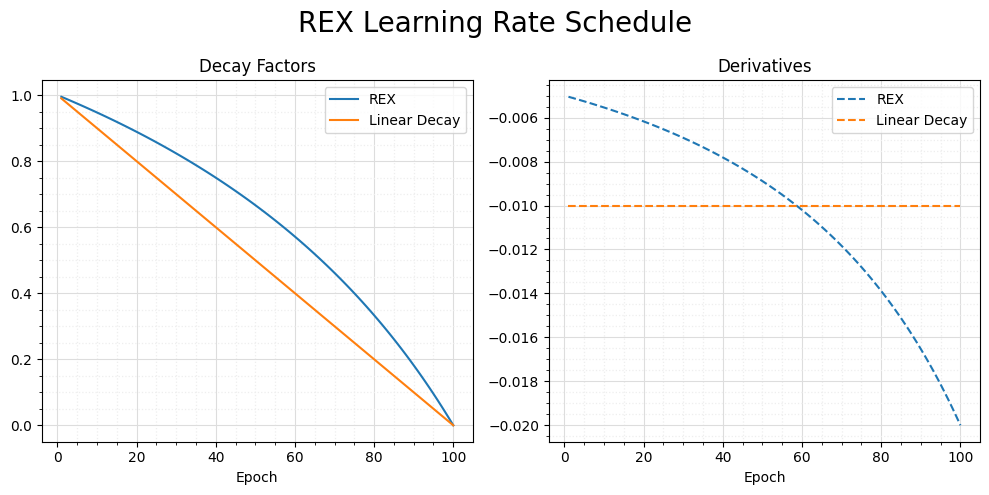

In [51]:
file_path = Path('reports/figures/results/rex-schedule.png')
file_path.parent.mkdir(parents=True, exist_ok=True)
save_plot = True if not file_path.exists() else False

# NOTE: The number of epochs qualitatively does not make any difference here
visualize_rex(100, save_plot)

**A note on the two plots**: On the *left*, we have plotted the decay factors instead of the learning rates (i.e., $\eta_t/\eta_0$ instead of $\eta_t$). On the *right*, we have plotted the derivatives (of the decay factors $\eta_t/\eta_0$) of the two schedules (i.e., REX and linear). This helps us better understand how the learning rate is adjusted in the REX schedule *compared to the linear decay schedule*.

We can see that, in the *REX* schedule, the learning rate is decreased less strongly in the earlier epochs and much more strongly in the later epochs compared to the *linear decay* schedule. *In theory*, this should allow our network to *learn more quickly* in the early stages of training while simultaneously keeping fluctuations in performance to a minimum at the later stages of training (as the learning rate is driven to $0$ more aggressively toward the end than in the linear schedule).

Finally, let's actually implement the *REX* learning rate scheduler.

In [52]:
class ReflectedExponentialLR(torch.optim.lr_scheduler.LRScheduler):
    """Implements a learning rate scheduler that uses a reflected exponential decay.

    This scheduler computes a learning rate factor based on a reflected exponential decay schedule
    and adjusts the learning rates for each parameter group accordingly.

    Args:
        optimizer (torch.optim.Optimizer): The optimizer used to update the model's weights.
        num_epochs (int): The number of epochs to train.
        last_epoch (int): The index of the last epoch.  Defaults to -1.
    """
    def __init__(
            self,
            optimizer: torch.optim.Optimizer,
            num_epochs: int,
            last_epoch: int = -1):
        self.num_epochs = num_epochs
        super().__init__(optimizer, last_epoch)
    
    def get_lr(self):
        if not self._get_lr_called_within_step:
            warnings.warn("To get the last learning rate computed by the scheduler, "
                          "please use `get_last_lr()`.", UserWarning)

        decay_factor = 2 * (self.num_epochs - self.last_epoch) / (2 * self.num_epochs - self.last_epoch)

        return [base_lr * decay_factor for base_lr in self.base_lrs]


### Training and Testing Routines

In this section, we collect all the functions that allow us to train, validate, and test a model. First, we implement a simple function that **runs a single epoch**. It returns the average loss and the average accuracy across the epoch as a tuple of floats.

In [53]:
def run_epoch(
        model: torch.nn.Module,
        dataloader: torch.utils.data.DataLoader,
        loss_fn: torch.nn.modules.loss._Loss,
        optimizer: torch.optim.Optimizer = None) -> tuple[float, float]:
    """Run a single epoch using the provided dataloader, loss_fn, and optimizer.

    Args:
        model (torch.nn.Module): The model to be trained/evaluated.
        dataloader (torch.utils.data.DataLoader): A dataloader providing samples.
        loss_fn (torch.nn.modules.loss._Loss): The loss function used for evaluation.
        optimizer (torch.optim.Optimizer): The optimizer used to update the model's weights.
            Defaults to None.

    Returns:
        tuple[float, float]: A tuple containing the average loss and accuracy.
    """
    # Set training/evaluation mode
    is_training = optimizer is not None
    model.train(is_training)

    # Initialize running totals
    running_samples = 0
    running_loss = 0.
    running_acc = 0.

    with (torch.set_grad_enabled(is_training)):
        for inputs, labels in dataloader:
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)

            # Keep track of the number of samples
            samples = len(labels)
            running_samples += samples

            # Forward pass
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)

            # Accumulate loss
            running_loss += loss.item() * samples

            # Compute accuracy
            acc = accuracy(outputs, labels)
            running_acc += acc[0].item() * samples

            # Backward pass and optimization
            if is_training:
                optimizer.zero_grad()  # zero gradients
                loss.backward()        # compute gradients
                optimizer.step()       # update weights
            
    # Compute average loss and accuracy over epoch
    avg_loss = running_loss / running_samples
    avg_acc = running_acc / running_samples

    return avg_loss, avg_acc


When we train a network, we usually train it for many epochs, where we **iteratively train it on the training set, validate it using the validation set, and repeat**. The next function does just that. Additionally, we implement the possibility to ...

- **resume training** by passing (the path to) a previously saved checkpoint to the function,
- specify the frequency at which **information** about the training progress is **printed to the console**,
- specify the frequency at which **checkpoints** are being saved (if at all).

**Note**: All of the checkpoints of training different models will be saved in the directory `models/` (relative to this notebook).

Now, let's get to the `train` function.

In [54]:
def train(
        model: torch.nn.Module,
        train_loader: torch.utils.data.DataLoader,
        val_loader: torch.utils.data.DataLoader,
        loss_fn: torch.nn.modules.loss._Loss,
        num_epochs: int,
        checkpoint_path: str = None,
        print_freq: int = None,
        save_freq: int = None,
        checkpoint_dir: str = None) -> dict[str, list[float]]:
    """Train a model for the specified number of epochs using the provided dataloaders, loss function, and optimizer.

    Args:
        model (torch.nn.Module): The model to be trained.
        train_loader (torch.utils.data.DataLoader): A dataloader providing training samples.
        val_loader (torch.utils.data.DataLoader): A dataloader providing validation samples.
        loss_fn (torch.nn.modules.loss._Loss): The loss function used for evaluation.
        num_epochs (int): The number of epochs to train.
        checkpoint_path (str): Path to the checkpoint from which to resume training.  Defaults to None.
        print_freq (int): Frequency (in number of epochs) at which to print information about
            the training progress.  Defaults to None.
        save_freq (int): Frequency (in number of epochs) at which to save checkpoints of the training progress.
            Defaults to None.  In this case, no checkpoints are saved.
        checkpoint_dir (str): The name of the subdirectory in which to save checkpoints.  Defaults to None.

    Returns:
        dict[str, list[float]]: A dictionary containing training logs.

    Raises:
        ValueError: If 'save_freq' is not 'None' and 'checkpoint_dir' is not a valid directory.
    """
    if save_freq:
        if checkpoint_dir is None:
            raise ValueError("Valid checkpoint directory must be provided when 'save_freq' is not None.")
        else:
            Path(MODELS_DIR, checkpoint_dir).mkdir(parents=True, exist_ok=True)

    # Resume training if the path to a saved checkpoint is passed
    if checkpoint_path:
        # Load checkpoint
        checkpoint = torch.load(checkpoint_path, map_location=DEVICE)

        # Load previous training logs
        init_epoch = checkpoint['epoch']
        train_logs = checkpoint['train_logs']
        best_acc = max(train_logs['val_acc'])

        # Load model's state_dict
        model.load_state_dict(checkpoint['model_state_dict'])
    else:
        # Initialize training logs
        init_epoch = 0
        train_logs = {
            'train_loss': [],
            'train_acc': [],
            'val_loss': [],
            'val_acc': []
            }
        best_acc = -1

    # Move model to target device
    model.to(DEVICE)

    # Set up optimizer and scheduler
    optimizer = torch.optim.SGD(
        model.parameters(),
        lr=LR,
        momentum=MOMENTUM,
        weight_decay=WEIGHT_DECAY
        )
    scheduler = ReflectedExponentialLR(optimizer, NUM_EPOCHS)

    # Load optimizer's and scheduler's state_dicts if training is to be resumed
    if checkpoint_path:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

    if print_freq is None:
        print_freq = num_epochs // 10

    # Iterate over epochs
    for epoch in range(init_epoch, init_epoch + num_epochs):
        train_loss, train_acc = run_epoch(model, train_loader, loss_fn, optimizer)
        val_loss, val_acc = run_epoch(model, val_loader, loss_fn)

        # Update learning rate
        scheduler.step()

        # Collect logs
        train_logs['train_loss'].append(train_loss)
        train_logs['train_acc'].append(train_acc)
        train_logs['val_loss'].append(val_loss)
        train_logs['val_acc'].append(val_acc)

        # Regularly print training progress to console
        if (epoch + 1) % print_freq == 0:
            print('Epoch [{:03d}/{:03d}]   Train   Loss={:.4f}   Acc={:.2f}    Val   Loss={:.4f}   Acc={:.2f}'.format(
                epoch + 1,                # epoch number
                init_epoch + num_epochs,  # total number of epochs
                train_loss,               # loss (training)
                train_acc,                # accuracy (training)
                val_loss,                 # loss (validation)
                val_acc                   # accuracy (validation)
                ))

        # Regularly save checkpoints
        if save_freq and (epoch + 1) % save_freq == 0:
            file_name = MODELS_DIR / checkpoint_dir / f'epoch-{epoch + 1:03d}_acc-{val_acc:.4f}.pt'
            save_checkpoint(
                epoch + 1,
                model,
                optimizer,
                scheduler,
                train_logs,
                file_name
                )

        # Save additional checkpoint for best-performing model (highest accuracy on validation set)
        if checkpoint_dir and val_acc > best_acc:
            best_acc = val_acc
            file_name = MODELS_DIR / checkpoint_dir / 'best_performing.pt'
            save_checkpoint(epoch + 1, model, optimizer, scheduler, train_logs, file_name)

    return train_logs


Once we have successfully trained a model, we want to **test its performance on a testing set** that the model has never seen before.

In [55]:
def test(
        model: torch.nn.Module,
        test_loader: torch.utils.data.DataLoader,
        loss_fn: torch.nn.modules.loss._Loss,
        print_results: bool = True) -> dict[str, float | int | dict[str, list[torch.Tensor | int]]]:
    """Evaluate a model on a test set using the provided dataloader and loss_fn.

    Args:
        model (torch.nn.Module): The model to be tested.
        test_loader (torch.utils.data.DataLoader): A dataloader providing test samples.
        loss_fn (torch.nn.modules.loss._Loss): The loss function used for evaluation.
        print_results (bool): Specifies whether results are to be printed.  Defaults to True.

    Returns:
        dict (dict[str, float | int | dict[str, list[torch.Tensor | int]]]): A dictionary containing the average test
        loss, test accuracy, total samples, number of errors, and the misclassified images and labels.
    """
    # Set evaluation mode
    model.eval()

    # Initialize running totals
    running_samples = 0
    running_loss = 0.
    running_acc = 0.
    running_errors = 0

    # Initialize dictionary to store info about misclassified samples
    misclassified = {
        'images': [],
        'labels': [],
        'predicted_labels': []
        }
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)

            # Keep track of the number of samples
            samples = len(labels)
            running_samples += samples

            # Forward pass
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)

            # Accumulate loss
            running_loss += loss.item() * samples

            # Compute accuracy
            acc = accuracy(outputs, labels)
            running_acc += acc[0].item() * samples

            # Determine misclassified samples
            _, predicted_labels = torch.max(outputs, dim=1)
            errors = predicted_labels != labels
            running_errors += torch.sum(errors).item()
            
            # Keep track of misclassified samples
            misclassified['images'].extend(inputs[errors])
            misclassified['labels'].extend(labels[errors])
            misclassified['predicted_labels'].extend(predicted_labels[errors])

    test_loss = running_loss / running_samples
    test_acc = running_acc / running_samples

    if print_results:
        print('\nTest Results   Loss={:.4f}   Acc={:.2f}   Samples correct: {:d}/{:d}'.format(
            test_loss,                         # loss
            test_acc,                          # accuracy
            running_samples - running_errors,  # correctly classified
            running_samples                    # total number of samples in the testing set
            ))

    test_results = {
        'test_loss': test_loss,
        'test_acc': test_acc,
        'total_samples': running_samples,
        'num_errors': running_errors,
        'misclassified': misclassified
        }

    return test_results


Finally, we define a function that lets us train a model on a single batch of inputs and labels. This will allow us to **overfit any model on a single batch**, which is a useful debugging method that's often used to make sure that the overall training pipeline is free of any major bugs.

In [56]:
def train_on_single_batch(
        model: torch.nn.Module,
        inputs: torch.Tensor,
        labels: torch.Tensor,
        loss_fn: torch.nn.modules.loss._Loss,
        num_epochs: int,
        print_freq: int = None) -> dict[str, list[float]]:
    """Train a model for the specified number of epochs on a single batch of samples.

    Args:
        model (torch.nn.Module): The model to be trained.
        inputs (torch.Tensor): The single batch of inputs for training.
        labels (torch.Tensor): The single batch of labels for training.
        loss_fn (torch.nn.modules.loss._Loss): The loss function used for evaluation.
        num_epochs (int): The number of epochs to train.
        print_freq (int): Frequency (in number of epochs) at which to print information about the training progress.
            Defaults to None.

    Returns:
        dict (dict[str, list[float]]): A dictionary containing training logs.
    """
    # Set training mode
    model.eval()

    # Move model to target device
    model.to(DEVICE)

    # Set up optimizer
    optimizer = torch.optim.SGD(
        model.parameters(),
        lr=LR,
        momentum=MOMENTUM,
        weight_decay=WEIGHT_DECAY
        )
    
    if print_freq is None:
        print_freq = num_epochs // 10

    # Initialize training logs
    train_logs = {
        'train_loss': [],
        'train_acc': []
        }

    inputs = inputs.to(DEVICE)
    labels = labels.to(DEVICE)

    for epoch in range(num_epochs):
        # Forward pass
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)

        # Compute accuracy
        acc = accuracy(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()  # zero gradients
        loss.backward()        # compute gradients
        optimizer.step()       # update weights

        # Collect logs
        train_logs['train_loss'].append(loss.item())
        train_logs['train_acc'].append(acc[0].item())

        if (epoch + 1) % print_freq == 0:
            print('Epoch [{:03d}/{:03d}]   Loss={:.4f}   Acc={:.2f}'.format(
                epoch + 1,     # epoch number
                num_epochs,    # total number of epochs
                loss.item(),   # loss
                acc[0].item()  # accuracy
            ))

    return train_logs


### Transforming and Augmenting Images

As mentioned before, there are $57$ different cards in a standard *Dobble* deck (for an unknown reason, there are only $55$ playing cards in the retailed version). This gives us $(57 \times 56) / 2 = 1,596$ different pairs of cards, which is the size of the full dataset that we'll be working with. If we split this dataset into training, validation, and testing sets using ratios of $70\%$, $15\%$, and $15\%$, respectively, we end up with a training set consisting of $1117$ images. We are already increasing the variability in our training data a bit by randomly assigning a position to each playing card in every epoch. Here, we want to improve the variability in our training data a bit further, by introducing image augmentation techniques.

However, before we do so, let's take care of the normalization of our data first. Since the images that we'll be using differ quite drastically from natural images, we will *not* be using the mean and standard deviation of common image databases such as [ImageNet](https://www.image-net.org/index.php). Instead, we use our `compute_mean_std` function to compute the mean and standard deviation of our data. We will do this as follows: Since the background color of each tile image is randomly chosen to be an arbitrary color (sampled from a uniform distribution), the average background color will be gray with a brightness of $50\%$ (if we sample often enough). Hence, we can compute the mean and standard deviation of the datasets that we'll be working with as follows:

In [57]:
# full_set_gray_bg = DobbleDataset(
#     pairs_csv, bg_color=(127, 127, 127),
#     preprocess=transforms.Compose([
#         transforms.ToImage(),
#         transforms.ToDtype(torch.float32, scale=True)
#         ]))

# BATCH_SIZE = 16
# full_set_gray_bg_loader = torch.utils.data.DataLoader(
#     full_set_gray_bg, batch_size=BATCH_SIZE
#     )

# MEAN, STD = calculate_mean_std(full_set_gray_bg_loader)

# MEAN = [round(val, 4) for val in MEAN]
# STD = [round(val, 4) for val in STD]

# print(f'MEAN: {MEAN}')
# print(f'STD: {STD}')

**Note**: Since the computation can be a bit time-consuming (depending on your setup), we have commented it out and simply hard-coded the values that we obtained from the computation:

In [58]:
MEAN = [0.6433, 0.635, 0.6188]
STD = [0.2535, 0.2543, 0.2659]

With these values at hand, we can define our **preprocessing transform** already.

In [59]:
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize(mean=MEAN, std=STD)
    ])

Later on, we will also be working with **ResNet** architectures of different depths. These require their own preprocessing as specified [here](https://pytorch.org/vision/main/models/generated/torchvision.models.resnet18.html#torchvision.models.resnet18).

**Note**: In PyTorch, [ResNet architectures](https://pytorch.org/vision/main/models/resnet.html) are available with those depths that were introduced in the original paper [Deep residual learning for image recognition](https://arxiv.org/pdf/1512.03385.pdf), i.e., 18, 34, 50, 101, and 152. The following **pre-trained weights** are available:

- `IMAGENET1K_V1`: Available for all ResNet models
- `IMAGENET1K_V2`: Available for all ResNet models *except* ResNet18 and ResNet34

Depending on the pre-trained models that are used (if any), the preprocessing differs in the first resizing step. We will **implement** the correct **preprocessing pipelines for both sets of pre-trained weights** (i.e., V1 and V2).

In [60]:
preprocess_imagenet1k_v1 = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
        )
    ])

preprocess_imagenet1k_v2 = transforms.Compose([
    transforms.Resize(232),  # only difference
    transforms.CenterCrop(224),
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
        )
    ])

With the preprocessing out of the way, we now turn to image augmentation. First, we implement a series of augmentations that we apply to the **images of the individual playing cards**.

In [61]:
individual_transform = transforms.RandomApply([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomPerspective(distortion_scale=0.4),
    transforms.RandomAffine(
        degrees=(0, 180),
        translate=(0.05, 0.05),
        scale=(0.8, 0.9)
        )
    ], p=0.75)

Additionally, we will also apply a simple augmentation to the **tile images of pairs of cards**.

In [62]:
tile_transform = transforms.ColorJitter(brightness=0.25, contrast=0.25)

Let's investigate the effects of these augmentations!

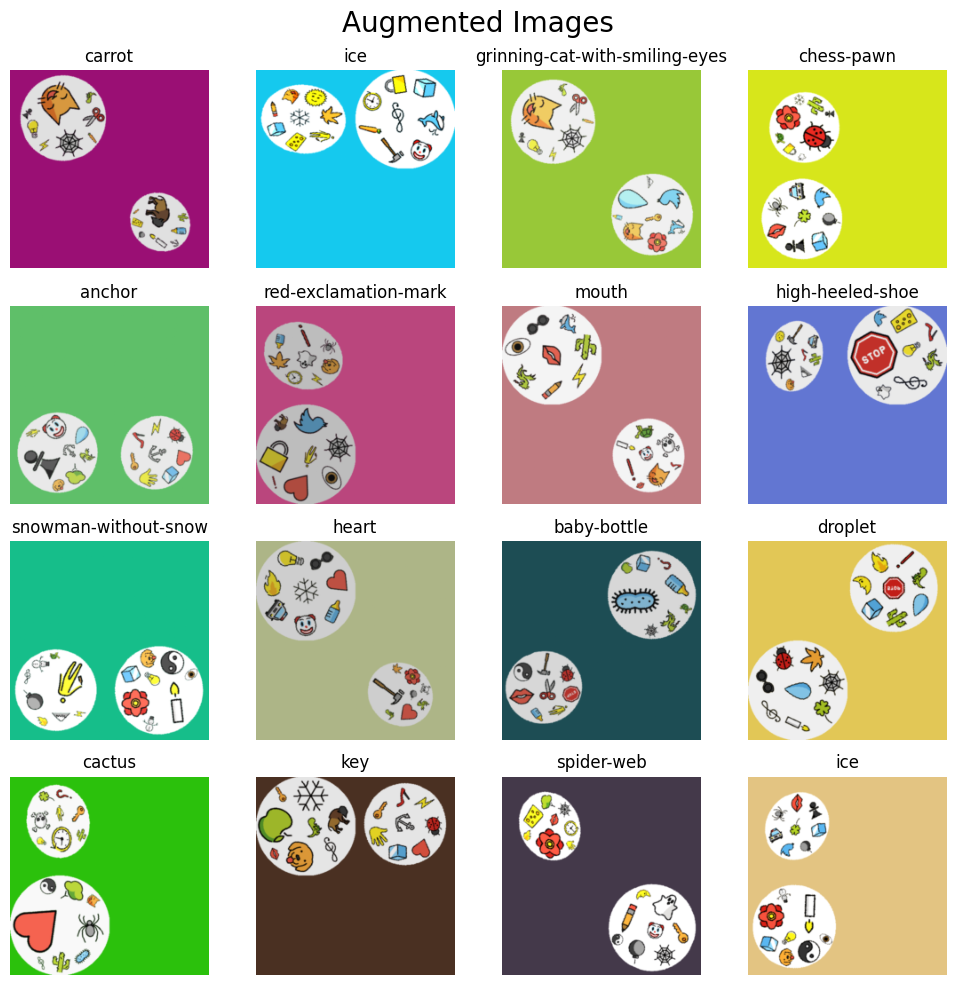

In [63]:
# Again, we set some random seeds for reproducibility
random.seed(0)        # identical cards & positioning
np.random.seed(0)     # identical background colors
torch.manual_seed(0)  # identical transforms

full_set = DobbleDataset(
    pairs_csv,
    individual_transform=individual_transform,
    tile_transform=tile_transform,
    preprocess=preprocess
    )

BATCH_SIZE = 16
NUM_WORKERS = 0

full_loader = torch.utils.data.DataLoader(
    full_set,
    batch_size=BATCH_SIZE,
    shuffle=True
    )

images, labels = next(iter(full_loader))
images_np = images.numpy()
images_np = np.transpose(images_np, (0, 2, 3, 1))  # (B, H, W, C)

fig, axes = plt.subplots(4, 4, figsize=(10, 10))
axes = axes.flatten()
file_path = Path('reports/figures/cards/image-augmentation.png')

for i, (image, label) in enumerate(zip(images_np, labels)):
    # Extract individual color channels
    r, g, b = image.transpose((2, 0, 1))

    # Undo normalization
    r = r * STD[0] + MEAN[0]
    g = g * STD[1] + MEAN[1]
    b = b * STD[2] + MEAN[2]

    # Recombine color channels and clip values to unit interval (necessary b/c of computational inaccuracies)
    image = np.dstack((r, g, b))
    image = np.clip(image, 0, 1)

    ax = axes[i]
    ax.imshow(image)
    ax.set_title(labels_dict[label.item()])
    ax.axis('off')

plt.suptitle('Augmented Images', size=20)
plt.tight_layout()
if not file_path.exists():
    _ = plt.savefig(file_path)
plt.show()

## ResNet Models of Different Depths

In this section, we will train *ResNet* models of different depths (keeping all other parameters constant) to see if the depth itself has an impact on the model performance.


### Parameters and Preparation

First, let's **set the target device** that we'll be using for training purposes.

In [64]:
DEVICE = torch.device(
    'cuda' if torch.cuda.is_available()
    else 'mps' if torch.backends.mps.is_available()
    else 'cpu'
    )
print(f'Target device: {DEVICE}')

Target device: mps


Next, let's set some (fixed) **parameters** that we'll use during training.

In [65]:
TRAIN_RATIO = 0.7
VAL_RATIO = 0.15

NUM_EPOCHS = 300

BATCH_SIZE = 64
NUM_WORKERS = 0

LR = 0.01
MOMENTUM = 0.9
WEIGHT_DECAY = 1e-4

LOSS_FN = nn.CrossEntropyLoss()
NUM_CLASSES = 57

PRINT_FREQ = 25
SAVE_FREQ = 50

RANDOM_SEED = 42

For each available depth (i.e., 18, 34, 50, 101, 152), we will have to **create the corresponding ResNet model** and replace the fully connected layer with one that has the appropriate size. Since this would lead to repetitive code, we write another little helper function that does this job for us.

In [66]:
def create_resnet_model(
        num_classes: int,
        depth: int,
        weights: str = None,
        random_seed: int = None) -> nn.Module:
    """Create a ResNet model of specified depth and with a specified number of classes.

    Args:
        num_classes (int): The number of output classes.
        depth (int): The depth of the ResNet model.  Supported depths are 18, 34, 50, 101, and 152.
        weights (str): If provided, the function loads pre-trained weights for the specified depth.
            Defaults to 'None', in which case the model will be randomly initialized.
        random_seed (int): If provided, the random seed will be used to initialize the model weights
            for reproducibility.  Defaults to 'None', in which case no random seed will be set.

    Returns:
        torch.nn.Module: The created ResNet model with the desired fully connected layer.

    Raises:
        ValueError: If an invalid depth is provided. Supported depths are 18, 34, 50, 101, and 152.
    """
    if random_seed:
        torch.manual_seed(random_seed)

    # Create model with specified pre-trained (or randomly initialized) weights
    available_depths = {
        18: models.resnet18,
        34: models.resnet34,
        50: models.resnet50,
        101: models.resnet101,
        152: models.resnet152
        }

    if depth not in available_depths:
        raise ValueError('Invalid depth. Supported depths are 18, 34, 50, 101, and 152.')
    else:
        model = available_depths[depth](weights=weights)

    # Replace fully connected layer
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features=in_features, out_features=num_classes)

    return model


Also, the **datasets and dataloaders** that we will be using will remain the same. So let's just create them right now.

In [67]:
train_csv, val_csv, test_csv = split_dataset(pairs_csv, TRAIN_RATIO, VAL_RATIO)

# We'll use image augmentation for our training set ...
train_set = DobbleDataset(
    train_csv,
    individual_transform=individual_transform,
    tile_transform=tile_transform,
    preprocess=preprocess
    )

# ... but not for our validation or testing sets
val_set = DobbleDataset(val_csv, preprocess=preprocess)
test_set = DobbleDataset(test_csv, preprocess=preprocess)

# Create dataloaders
train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS
    )

val_loader = torch.utils.data.DataLoader(
    val_set,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS
    )

test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS
    )

### ResNet-18

To make sure that our `train` function works as expected, we will first train Resnet-18 for 100 epochs, and then try to resume training and train it for another 200 epochs so that we have trained for a total of 300 epochs, as set by our argument `NUM_EPOCHS`. We also set random seeds so that we can reprodruce the exact training results later on. Besides calling `torch.manual_seed()`, we also have to set seeds for `random` and `numpy`. This is due to the fact that

- `random` is involved in determining the positions of playing cards when creating the tile images,
- `numpy` is used to randomly set the background color of the tile images.

Not setting random seeds for these two packages would result in different training and validation samples because the samples (tile images) are generated on the fly by the dataloader created from the `DobbleDataset` class.

In [68]:
# # Instantiate ResNet-18 model
# resnet18 = create_resnet_model(NUM_CLASSES, depth=18, random_seed=RANDOM_SEED)

# # Random seeds for reproducibility of training results
# random.seed(RANDOM_SEED)
# np.random.seed(RANDOM_SEED)
# torch.manual_seed(RANDOM_SEED)

# # We deviate from 'NUM_EPOCHS' to test our 'train' function ...
# num_epochs = 100

# resnet18_train_logs = train(
#     resnet18,
#     train_loader,
#     val_loader,
#     LOSS_FN,
#     num_epochs,
#     print_freq=PRINT_FREQ,
#     save_freq=SAVE_FREQ,
#     checkpoint_dir='resnet18'
#     )

checkpoint = torch.load(
    'models/resnet18/epoch-100_acc-61.0879.pt',
    map_location='cpu'
    )
train_logs = checkpoint['train_logs']
reprint_logs(train_logs, print_freq=PRINT_FREQ)

Epoch [025/100]   Train   Loss=3.8498   Acc=4.74    Val   Loss=4.1519   Acc=3.77
Epoch [050/100]   Train   Loss=2.8890   Acc=19.87    Val   Loss=6.1811   Acc=2.51
Epoch [075/100]   Train   Loss=1.5020   Acc=57.92    Val   Loss=3.6937   Acc=14.64
Epoch [100/100]   Train   Loss=0.4595   Acc=90.69    Val   Loss=1.1209   Acc=61.09


In [69]:
# # ... and here we train the remaining 200 epochs!
# num_epochs = 200

# # Select the checkpoint that we saved earlier ...
# checkpoint_path = 'models/resnet18/epoch-100_acc-61.0879.pt'

# # ... and resume the training progress.
# resnet18_train_logs = train(
#     resnet18,
#     train_loader,
#     val_loader,
#     LOSS_FN,
#     num_epochs,
#     checkpoint_path=checkpoint_path,
#     print_freq=PRINT_FREQ,
#     save_freq=SAVE_FREQ,
#     checkpoint_dir='resnet18'
#     )

checkpoint = torch.load(
    'models/resnet18/epoch-300_acc-99.5816.pt',
    map_location='cpu'
    )
train_logs = checkpoint['train_logs']
reprint_logs(train_logs, start_after=100, print_freq=PRINT_FREQ)

Epoch [125/300]   Train   Loss=0.1309   Acc=99.10    Val   Loss=0.9341   Acc=72.38
Epoch [150/300]   Train   Loss=0.0662   Acc=99.91    Val   Loss=0.2203   Acc=97.49
Epoch [175/300]   Train   Loss=0.0429   Acc=99.82    Val   Loss=0.0954   Acc=99.58
Epoch [200/300]   Train   Loss=0.0356   Acc=100.00    Val   Loss=0.0937   Acc=100.00
Epoch [225/300]   Train   Loss=0.0280   Acc=100.00    Val   Loss=0.0476   Acc=100.00
Epoch [250/300]   Train   Loss=0.0235   Acc=100.00    Val   Loss=0.0482   Acc=99.58
Epoch [275/300]   Train   Loss=0.0198   Acc=100.00    Val   Loss=0.0380   Acc=100.00
Epoch [300/300]   Train   Loss=0.0182   Acc=100.00    Val   Loss=0.0388   Acc=99.58


Let's take a look at the results!

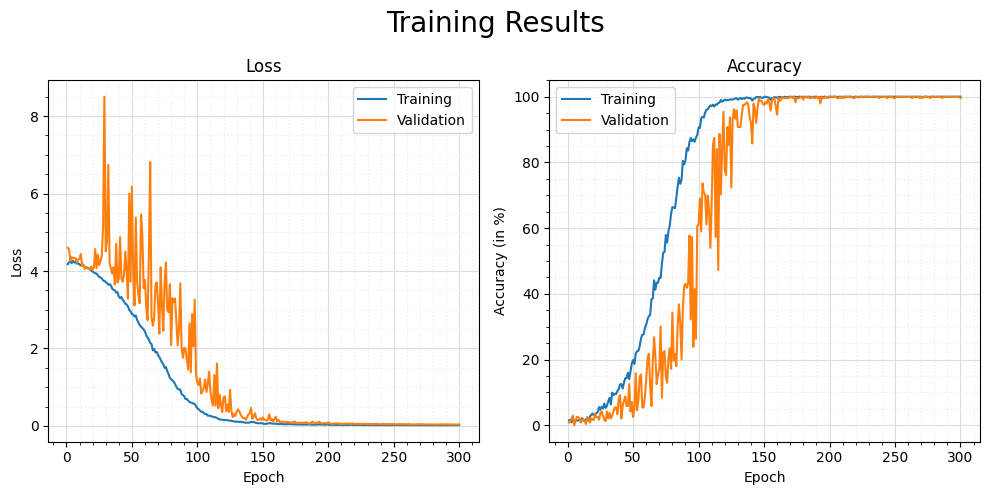

In [70]:
checkpoint = torch.load(
    'models/resnet18/epoch-300_acc-99.5816.pt',
    map_location='cpu'
    )

figure_title = 'resnet18-training.png'
file_path = Path('reports/figures/results', figure_title)
save_plot = not file_path.exists()
plot_loss_and_accuracy(checkpoint['train_logs'], save_plot, figure_title)

### Remaining ResNet Models

Now, let's systematically train the remaining ResNet models that are available in PyTorch.

In [71]:
# resnet_depths = [34, 50, 101, 152]

# for count, depth in enumerate(resnet_depths):
#     if count > 0:
#         print('\n\n')

#     print(f'CURRENTLY TRAINING: RESNET-{depth}\n')

#     resnet = create_resnet_model(NUM_CLASSES, depth=depth, random_seed=RANDOM_SEED)

#     # Random seeds for reproducibility of training results
#     random.seed(RANDOM_SEED)
#     np.random.seed(RANDOM_SEED)
#     torch.manual_seed(RANDOM_SEED)

#     _ = train(
#         resnet,
#         train_loader,
#         val_loader,
#         LOSS_FN,
#         NUM_EPOCHS,
#         print_freq=PRINT_FREQ,
#         save_freq=SAVE_FREQ,
#         checkpoint_dir=f'resnet{depth}'
#         )

checkpoints = {
    34: 'resnet34/epoch-300_acc-100.0000.pt',
    50: 'resnet50/epoch-300_acc-97.4895.pt',
    101: 'resnet101/epoch-300_acc-89.1213.pt',
    152: 'resnet152/epoch-300_acc-68.2008.pt'
    }

for count, (depth, checkpoint_path) in enumerate(checkpoints.items()):
    if count > 0:
        print('\n\n')
    
    print(f'CURRENTLY TRAINING: RESNET-{depth}\n')
    
    checkpoint = torch.load(
        MODELS_DIR / checkpoint_path,
        map_location='cpu'
        )
    train_logs = checkpoint['train_logs']
    reprint_logs(train_logs, print_freq=PRINT_FREQ)

CURRENTLY TRAINING: RESNET-34

Epoch [025/300]   Train   Loss=4.0574   Acc=2.15    Val   Loss=4.0820   Acc=1.26
Epoch [050/300]   Train   Loss=3.9758   Acc=2.69    Val   Loss=3.9862   Acc=2.09
Epoch [075/300]   Train   Loss=3.8053   Acc=5.10    Val   Loss=4.0809   Acc=1.67
Epoch [100/300]   Train   Loss=3.2984   Acc=13.16    Val   Loss=4.5070   Acc=3.77
Epoch [125/300]   Train   Loss=2.2521   Acc=31.60    Val   Loss=3.6764   Acc=12.55
Epoch [150/300]   Train   Loss=0.7602   Acc=80.30    Val   Loss=3.2482   Acc=20.08
Epoch [175/300]   Train   Loss=0.1582   Acc=98.30    Val   Loss=0.6869   Acc=80.33
Epoch [200/300]   Train   Loss=0.0672   Acc=99.55    Val   Loss=0.2090   Acc=97.07
Epoch [225/300]   Train   Loss=0.0402   Acc=99.91    Val   Loss=0.0632   Acc=100.00
Epoch [250/300]   Train   Loss=0.0293   Acc=99.91    Val   Loss=0.0613   Acc=100.00
Epoch [275/300]   Train   Loss=0.0234   Acc=100.00    Val   Loss=0.0460   Acc=100.00
Epoch [300/300]   Train   Loss=0.0204   Acc=100.00    Val  

Judging from the messages printed during training, we observe a similar pattern for all ResNet architectures: Training progresses very slowly at the beginning (i.e., training loss decreases only incrementally). Once the loss drops below $4.0$, it tends to decrease close to $0$ very quickly. What we notice is that, for some architectures, this point of dropping below $4.0$ seems to happen a bit *too late* so that the model does not reach a very high accuracy within $300$ epochs of training. However, from this single run of training the different models, we cannot infer that the deeper ResNet models are less suited to our task. Instead, it *does seem* that all of the models would reach near-perfect accuracy if the training duration (i.e., number of epochs) was adjusted accordingly, and that the speed at which the models reach near-perfect accuracy depends on the size of the model (i.e., the number of parameters), which makes perfect sense.

**Note**: While we did set a random seed, this still doesn't set up a level playing field across models of different depths, since these have different numbers of parameters that need to be initialized randomly!

Finally, let's **plot the training results** so we can take another look at them!

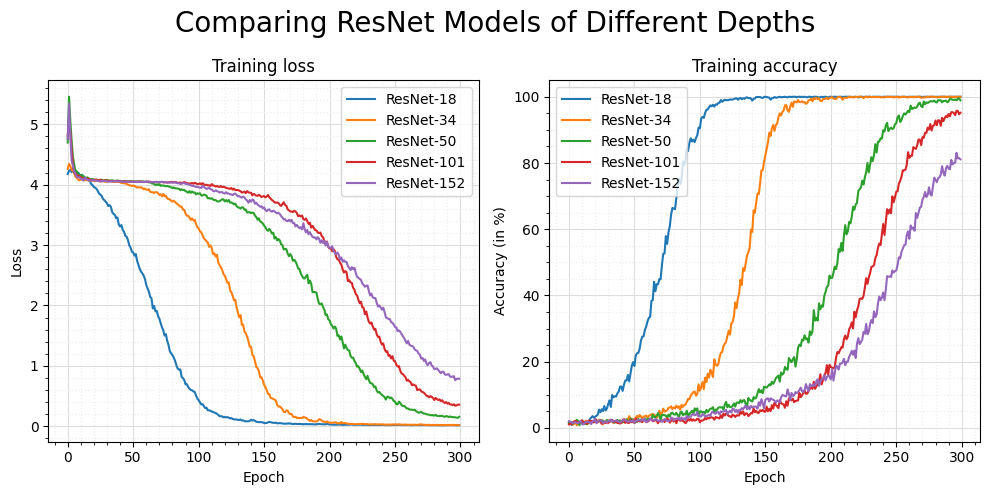

In [72]:
# Provide file paths to checkpoints
checkpoints = {
    18: 'resnet18/epoch-300_acc-99.5816.pt',
    34: 'resnet34/epoch-300_acc-100.0000.pt',
    50: 'resnet50/epoch-300_acc-97.4895.pt',
    101: 'resnet101/epoch-300_acc-89.1213.pt',
    152: 'resnet152/epoch-300_acc-68.2008.pt'
    }

# Iteratively load training logs for all ResNet models
resnet_train_logs = dict()

for depth, checkpoint_path in checkpoints.items():
    checkpoint = torch.load(
        MODELS_DIR / checkpoint_path,
        map_location='cpu'
        )
    resnet_train_logs[depth] = checkpoint['train_logs']

# Plot (training) loss and accuracy of all models
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
file_path = Path('reports/figures/results/resnet-comparison.png')

for i, ax in enumerate(axes):  # loss (i=0) and accuracy (i=1)
    for depth, train_logs in resnet_train_logs.items():
        logs = train_logs['train_loss'] if i == 0 else train_logs['train_acc']
        ax.plot(range(len(logs)), logs, label=f'ResNet-{depth}')
        
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss' if i == 0 else 'Accuracy (in %)')
    ax.set_title('Training loss' if i == 0 else 'Training accuracy')
    ax.legend()
    ax.grid(which='major', color='#DDDDDD')
    ax.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.9)
    ax.minorticks_on()

plt.suptitle('Comparing ResNet Models of Different Depths', size=20)
plt.tight_layout()
if not file_path.exists():
    _ = plt.savefig(file_path)
plt.show()

What we see here confirms what we have already inferred from the regular print-outs during training: **All of the models seem capable of learning to solve the task with near-perfect accuracy.** Also, there seems to be a threshold just around a training loss of $4.0$. Once the loss drops below this value, it decreases exponentially. This effect *seems to be* slightly less pronounced for the larger models (i.e., ResNet-50, ResNet-101, and ResNet-152). However, this is likely due to the REX learning rate scheduler that we have implemented, which drives the learning rate towards $0$ at the end of the 300 training epochs. Loosely speaking, once the larger models figured out *where to go*, it was already too late. Nevertheless, based on the data plotted above, it seems *highly likely* that we could've also achieved near-perfect accuracy with the deeper ResNet models had we trained them for more epochs.